### PROJECT MCMULTY

#### AWS MySQL RDS Contents:
- business.db (30M)
- tip.db (141M)
- review.db (3.5G)
- checkin.db (4.8M)
- business_hours.db (13M)
- user.db (1.3G)

<center>**Click below for all other data information** </center>
[![](https://s3-media2.fl.yelpcdn.com/assets/srv0/styleguide/1ea40efd80f5/assets/img/brand_guidelines/yelp_fullcolor.png)](https://www.yelp.com/dataset/documentation/json)

### Table of Contents
1. [AWS RDS Connection](#0)
2. [Import Data](#2)<br>
     2.1 [Read yelp data from RDS](#2.1)<br>
     2.2 [Read supplement data from csv and convert all sub-categories to primary categories](#2.2)<br>
3. [Exploratory Data Analysis](#3)<br>
     3.1 [Visualize star rating distribution](#3.1)<br>
     3.2 [Visualize category distribution](#3.2)<br>
     3.3 [Visualize Review Counts by City Distribution](#3.3)<br>
4. [Data Cleaning](#4)<br>
5. [Feature Engineering](#4)<br>
     5.1 [Calculate number of business days within a week](#5.1)<br>
     5.2 [Calculate number of business hours within a week](#5.2)<br>
     5.3 [Extract the length of the business unit](#5.3)<br>
     5.4 [Extract number of vowels in the business name](#5.4)<br>
     5.5 [Extract number of friends on Yelp](#5.5)<br>
     5.6 [Final data cleaning prior to modeling](#5.6)<br>
6. [Baseline Model](#6)<br>
     6.1 [Define classification metrics function & downcasting function](#6.1)<br>
     6.2 [Baseline Logistic Regression model (One feature)](#6.2)<br>
     6.3 [Expanding Logistic Regression with 5 original features](#6.3)<br>
     6.4 [Expanding Logistic Regression with 5 feature engineered features](#6.4)<br>
     6.5 [Expanding Logistic Regression with 10 features](#6.5)<br>
     6.6 [Logistic Regression Model (All features)](#6.6)<br>
     6.7 [Baseline RF model (One feature)](#6.7)<br>
     6.8 [Baseline xgBoost model (One feature)](#6.8)<br>
     6.9 [RF model (All features)](#6.9)<br>
     6.10 [xgBoost model (All feature)](#6.10)<br>
7. [Natural Language Processing (NLP) as additional features](#7)<br>
     7.1 [TFIDFVectorizer](#7.1)<br>
     7.2 [RF Model (TFIDF + all features)](#7.2)<br>
     7.3 [xgBoost model (TFIDF + all features)](#7.3)<br>
8. [Model Optimization](#8)<br>
9. [Final test-scores](#9)<br>

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import mysql.connector as sql
import math
import itertools
from functools import reduce
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from itertools import groupby
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

### <a id=0></a>1. Define AWS RDS endpoint connection

<a href="url"><center><img src="https://github.com/whosivan/sf18_ds9/blob/master/student_submissions/projects/luther/Cui_Ivan/AWS_setup.png?raw=true" align="left" height="480" width="480" ></center></a>

In [2]:
db_connection = sql.connect(host = 'yelpinstance.cvchd2jvtnxy.us-east-1.rds.amazonaws.com', 
                            database = 'yelpdb', 
                            user = 'root', 
                            password = 'admin123')

### <a id=2></a> 2. Import Data

#### <a id=2.1></a> 2.1 Read yelp data from RDS

In [3]:
%time
business_df = pd.read_sql('''
select b.business_id, b.name as business_name, b.city, b.state, b.stars as business_stars, b.review_count, b.is_open, b.categories, bh.monday, bh.tuesday, bh.wednesday, bh.thursday, bh.friday, bh.saturday, bh.sunday
from business as b
join business_hours as bh
on b.business_id = bh.business_id
''', con = db_connection)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [4]:
%time
review_df = pd.read_sql('''SELECT user_id,
                                  business_id,
                                  stars,
                                  text as review_text,
                                  useful as r_review,
                                  funny as r_funny, 
                                  cool as r_cool FROM review LIMIT 1000000''', con = db_connection)
tip_df = pd.read_sql('''SELECT business_id,
                               count(text) as tip_count FROM tip
                               group by 1''', con = db_connection)
checkin_df = pd.read_sql('''SELECT business_id,
                                   checkins FROM checkin''', con = db_connection)
user_df = pd.read_sql('''SELECT user_id,
                                name as user_name,
                                review_count as user_review_counts,
                                friends,
                                useful as u_useful,
                                funny as u_funny,
                                cool as u_cool,
                                fans as u_fans,
                                average_stars,
                                compliment_cute,
                                compliment_more,
                                compliment_profile,
                                compliment_cute,
                                compliment_list,
                                compliment_note,
                                compliment_plain,
                                compliment_cool,
                                compliment_funny,
                                compliment_writer,
                                compliment_photos FROM user''', con = db_connection)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 178 µs


#### <a id=2.2></a> 2.2 Read supplement data from csv and convert all sub-categories to primary categories

In [44]:
category_list = pd.read_csv('../yelp_data/yelp-business-categories.csv')
category_list.drop_duplicates(subset='Sub-Categories', keep="first", inplace=True)

def pd_to_dict(df):
    category_dict = {k: g["Sub-Categories"].tolist() for k,g in df.groupby("Primary_Categories")}
    category_dict = dict((v,k) for k in category_dict for v in category_dict[k])
    return category_dict

category_dict = pd_to_dict(category_list)

In [45]:
def get_primary_category_label(df):
    df.categories = df.categories.apply(lambda x:x.rstrip('\r')).str[0:].str.split(';')
    df.categories = df.categories.apply(lambda col: col[0])
    return df

get_primary_category_label(business_df).head(1)

AttributeError: 'DataFrame' object has no attribute 'categories'

In [7]:
def map_main_category(df, dict_):
    df['primary_category'] = df['categories'].map(dict_)
    df.drop(['categories'], axis =1, inplace=True)
    return df

map_main_category(business_df, category_dict).head(1)

,business_id,business_name,city,state,business_stars,review_count,is_open,monday,tuesday,wednesday,thursday,friday,saturday,sunday,primary_category
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,7:30-17:0,7:30-17:0,7:30-17:0,7:30-17:0,7:30-17:0,None,None,Health & Medical


### <a id=3></a> 3. Exploratory Data Analysis

#### <a id=3.1></a>3.1 Visualize star rating distribution

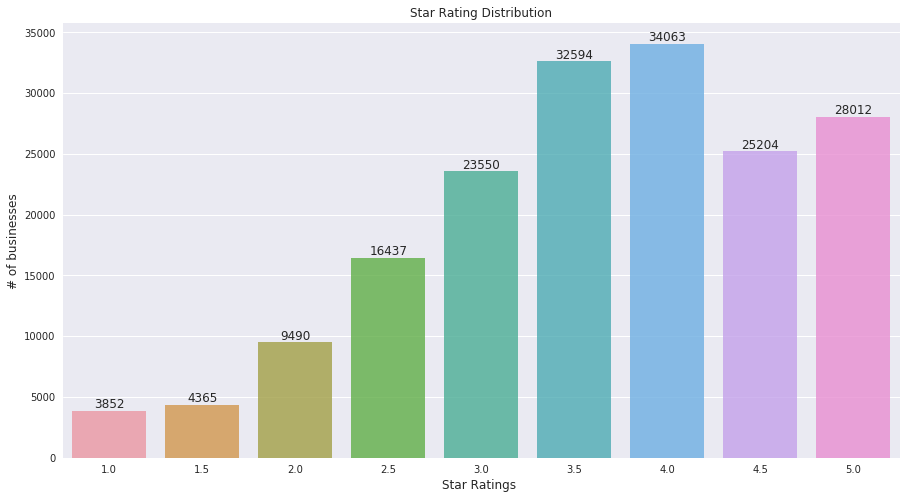

In [8]:
#Get the distribution of the ratings
x = business_df['business_stars'].value_counts().sort_index()
#plot
plt.figure(figsize=(15, 8))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### <a id=3.2></a>3.2 Visualize category distribution

There are  21  different types/categories of Businesses in Yelp.
Number of business in Top20: 94727


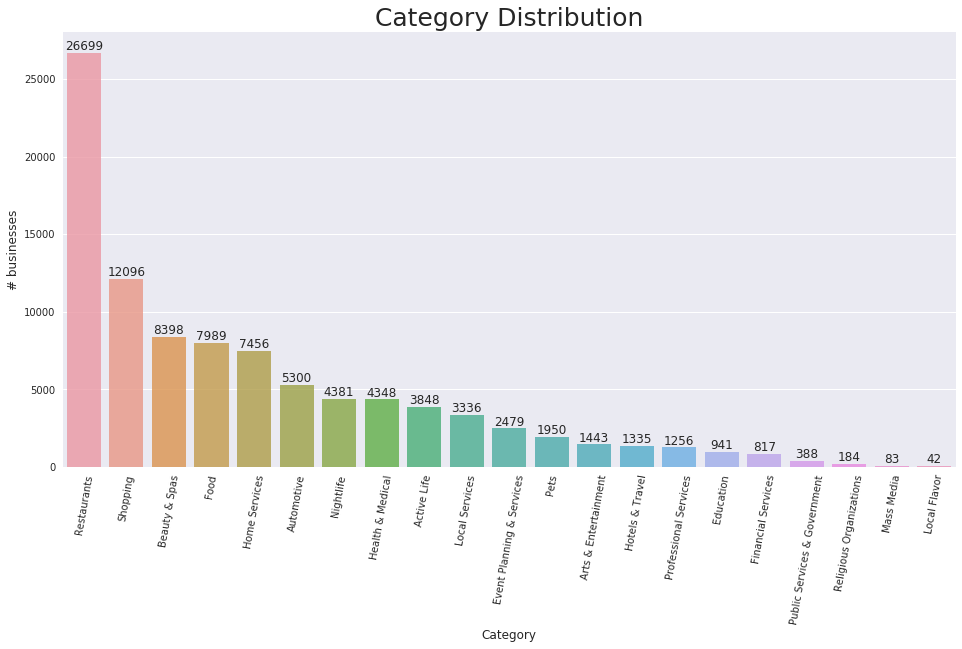

In [9]:
x = business_df.primary_category.value_counts()
print("There are ",len(x)," different types/categories of Businesses in Yelp.")
count = 0
for index, num in enumerate(x.iloc[0:20]):
    count += num
print('Number of business in Top20: {}'.format(count))

#prep for chart
x = x.sort_values(ascending = False)
top_categories = x.index.tolist()

#chart
plt.figure(figsize = (16,8))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Category Distribution",fontsize = 25)
locs, labels = plt.xticks()
plt.setp(labels, rotation = 80)
plt.ylabel('# businesses', fontsize = 12)
plt.xlabel('Category', fontsize = 12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = 'center', va = 'bottom')

plt.show()

#### <a id=3.3></a> 3.3 Visualize Review Counts by City Distribution 

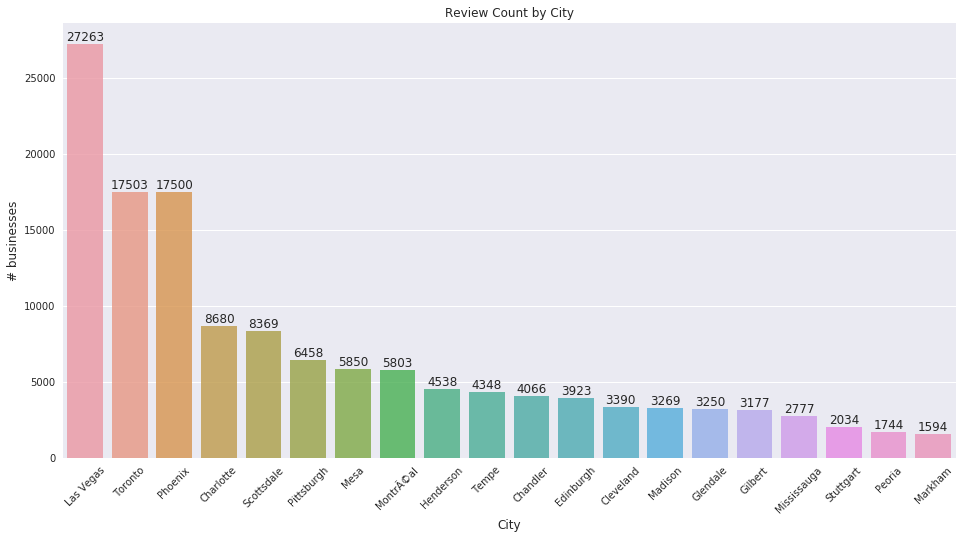

In [10]:
x = business_df['city'].value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(16,8))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Review Count by City")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = 'center', va = 'bottom')

plt.show()

### <a id=4></a> 4. Data Mining

In [8]:
print('business+business_hours df shape: {}'.format(business_df.shape))
print('review df shape: {}'.format(review_df.shape))
print('tip df shape: {}'.format(tip_df.shape))
print('checkin df shape: {}'.format(checkin_df.shape))
print('user df shape: {}'.format(user_df.shape))

business+business_hours df shape: (177567, 15)
review df shape: (1000000, 7)
tip df shape: (112365, 2)
checkin df shape: (146350, 2)
user df shape: (565000, 20)


In [9]:
# dfs = [business_df, tip_df, checkin_df, review_df]
# df2 = reduce(lambda left,right: pd.merge(left,right,on='business_id'), dfs)
# maindf = pd.merge(df2, user_df, how='inner', on='user_id')
# maindf.describe()

In [10]:
#join tables
testdf = pd.merge(business_df, tip_df, how='inner', on='business_id')
testdf2 = pd.merge(testdf, checkin_df, how='inner', on='business_id')
testdf3 = pd.merge(testdf2, review_df, how='inner', on='business_id')
maindf = pd.merge(testdf3, user_df, how='inner', on='user_id')

In [11]:
maindf.shape

(396670, 42)

In [12]:
maindf.describe()

,business_stars,review_count,is_open,tip_count,checkins,stars,r_review,r_funny,r_cool,user_review_counts,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,...,396670.000000,396670.00000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.000000,396670.00000
mean,3.723958,380.605294,0.882502,84.677909,8.090125,3.719018,1.376260,0.527305,0.620299,135.702261,...,3.306514,2.18380,1.672395,1.018733,19.791492,47.913283,41.503529,41.503529,14.957811,14.46430
std,0.696464,759.525684,0.322013,193.187719,33.073019,1.413837,4.128653,2.329678,2.482776,412.268904,...,23.389505,22.86918,16.053899,9.862551,251.082301,345.785851,288.868014,288.868014,96.990437,161.14956
min,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.500000,45.000000,1.000000,7.000000,1.000000,3.000000,0.000000,0.000000,0.000000,8.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.000000,128.000000,1.000000,24.000000,2.000000,4.000000,0.000000,0.000000,0.000000,26.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,4.000000,358.000000,1.000000,77.000000,5.000000,5.000000,2.000000,0.000000,1.000000,104.000000,...,1.000000,0.00000,0.000000,0.000000,3.000000,4.000000,3.000000,3.000000,2.000000,1.00000
max,5.000000,7361.000000,1.000000,3517.000000,861.000000,5.000000,1212.000000,410.000000,234.000000,8353.000000,...,3820.000000,6251.00000,2013.000000,2346.000000,56960.000000,13006.000000,14180.000000,14180.000000,6098.000000,22632.00000


In [13]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396670 entries, 0 to 396669
Data columns (total 42 columns):
business_id           396670 non-null object
business_name         396670 non-null object
city                  396670 non-null object
state                 396670 non-null object
business_stars        396670 non-null float64
review_count          396670 non-null int64
is_open               396670 non-null int64
monday                396670 non-null object
tuesday               396670 non-null object
wednesday             396670 non-null object
thursday              396670 non-null object
friday                396670 non-null object
saturday              396670 non-null object
sunday                396670 non-null object
primary_category      232285 non-null object
tip_count             396670 non-null int64
checkins              396670 non-null int64
user_id               396670 non-null object
stars                 396670 non-null int64
review_text           396670 non-null 

### <a id=5></a>5. Feature Engineering

#### <a id=5.1></a> 5.1 Calculate number of business days within a week

In [14]:
weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
weekends = ['saturday', 'sunday']

def business_days(df):
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
    weekends = ['saturday', 'sunday']
    temp = df[weekdays+weekends].replace('None', np.nan)
    df['number_of_business_days'] = 7 - temp.isnull().sum(axis = 1)
    return df

business_days(maindf).sample(1, random_state = 5)

,business_id,business_name,city,state,business_stars,review_count,is_open,monday,tuesday,wednesday,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,number_of_business_days
102820,iGpQdPxvOI7eWeSTYMnNeA,"""The Pittsburgh Juice Co""",Pittsburgh,PA,4.0,38,1,7:0-18:30,7:0-18:30,7:0-18:30,...,0,0,0,0,0,0,0,0,0,7


In [15]:
#how many business on list has no records of opening
print('Total records with 0 business hours: {}'.format(len(maindf.loc[maindf.number_of_business_days == 0])))

Total records with 0 business hours: 32805


In [16]:
#how many business on list that is not open?
print('Total records shown as not open: {}'.format(len(maindf.loc[maindf.is_open == 0])))

Total records shown as not open: 46608


#### <a id = 5.2></a> 5.2 Calculate number of business hours within a week

In [17]:
def business_hours(df):
    days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    store_hours = pd.DataFrame()

    for i in range(len(days)):
        temp = pd.DataFrame(df[days[i]].replace(to_replace='None', value='0-0'))
        temp[['t1','t2']] = pd.DataFrame(temp[days[i]].str.split('-').values.tolist(), index = temp.index)
        temp['hh1'], temp['mm1'] = temp['t1'].str.split(':', 1).str
        temp['hh2'], temp['mm2'] = temp['t2'].str.split(':', 1).str
        temp['hours'] = temp['hh2'].astype(int) - temp['hh1'].astype(int)
        temp.hours[temp.hours < 0] = 24 - temp.hh1.astype(int) + temp.hh2.astype(int)
        store_hours[i] = temp.hours
    
    df['total_business_hours'] = store_hours.sum(axis=1)
    df.drop(days, axis = 1, inplace = True)
    
    return df
business_hours(maindf).head(1)

,business_id,business_name,city,state,business_stars,review_count,is_open,primary_category,tip_count,checkins,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,number_of_business_days,total_business_hours
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,Health & Medical,5,1,...,16,1,302,627,568,568,160,58,5,50


#### <a id=5.3></a> 5.3 Extract the length of the business name

In [18]:
def business_name_length(df):
    df['business_name_length'] = df['business_name'].apply(lambda x:len(x.split(' ')))
    return df

business_name_length(maindf).head(1)

,business_id,business_name,city,state,business_stars,review_count,is_open,primary_category,tip_count,checkins,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,number_of_business_days,total_business_hours,business_name_length
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,Health & Medical,5,1,...,1,302,627,568,568,160,58,5,50,3


#### <a id=5.4></a> 5.4 Extract number of vowels in the business name

In [19]:
def vowels_in_business_name(df):
    vow_list = []
    for title in df.business_name:
        vow = 0
        word = title.split(' ')
        for w in word:
            ws = w.lstrip('"').rstrip('"')
            vow += sum(letter in 'aeiou' for letter in ws.lower())
        vow_list.append(vow)

    df['number_of_vowels_in_business_name'] = vow_list
    return df

vowels_in_business_name(maindf).head(1)

,business_id,business_name,city,state,business_stars,review_count,is_open,primary_category,tip_count,checkins,...,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,number_of_business_days,total_business_hours,business_name_length,number_of_vowels_in_business_name
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,Health & Medical,5,1,...,302,627,568,568,160,58,5,50,3,4


#### <a id=5.5></a> 5.5 Extract number of friends on Yelp

In [22]:
def number_of_friends(df):
    df['number_of_friends'] = df.friends.replace('None', np.nan).str.split(', ').str.len()
    df['number_of_friends'] = df['number_of_friends'].fillna(0.0).astype(int)
    df.drop(['friends'], axis = 1)
    return df

number_of_friends(maindf).head(1)

,business_id,business_name,city,state,business_stars,review_count,is_open,primary_category,tip_count,checkins,...,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,number_of_business_days,total_business_hours,business_name_length,number_of_vowels_in_business_name,number_of_friends
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,Health & Medical,5,1,...,627,568,568,160,58,5,50,3,4,515


#### <a id=5.6></a> 5.6 Final data cleaning prior to modeling

In [23]:
def drop_cols_post_feature_engineering(df):
    drop_final_maindfcol = ['user_id', 'user_id_y', 'review_id', 'business_id', 'friends']
    df.drop(drop_final_maindfcol, axis = 1, inplace = True)
    return df

drop_cols_post_feature_engineering(maindf).head(1)

,business_name,city,state,business_stars,review_count,is_open,primary_category,tip_count,checkins,stars,...,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,number_of_business_days,total_business_hours,business_name_length,number_of_vowels_in_business_name,number_of_friends
0,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,Health & Medical,5,1,3,...,627,568,568,160,58,5,50,3,4,515


### <a id=6></a> 6. Baseline Model

#### <a id=6.1></a> 6.1 Define classification metrics function & downcasting function

In [48]:
yelp_df = maindf.copy()
yelp_df.fillna('Others',inplace=True)

In [49]:
# Reset dtypes
temp_dtypes = {
    'business_stars': np.float32,
    'review_count': np.int32,
    'is_open': np.int8,
    'tip_count': np.int32,
    'checkins': np.int32,
    'stars': np.int32,
    'r_review': np.int32,
    'r_funny': np.int32,
    'r_cool': np.int32,
    'user_review_counts': np.int32,
    'u_useful': np.int32,
    'u_funny': np.int32,
    'u_cool': np.int32,
    'u_fans': np.int32,
    'average_stars': np.float32,
    'compliment_cute': np.int32,
    'compliment_more': np.int32,
    'compliment_profile': np.int32,
    'compliment_cute': np.int32,
    'compliment_list': np.int32,
    'compliment_note': np.int32,
    'compliment_plain': np.int32,
    'compliment_cool': np.int32,
    'compliment_funny': np.int32,
    'compliment_writer': np.int32,
    'compliment_photos': np.int32,
    'number_of_business_days': np.int32,
    'total_business_hours': np.int32,
    'business_name_length': np.int32,
    'number_of_vowels_in_business_name': np.int32,
    'number_of_friends': np.int32,
    }

for col, col_type in temp_dtypes.items():
    yelp_df[col] = yelp_df[col].astype(col_type)

In [50]:
def classification_loops(df, x, y, model_list, model_names_list):
    scores_table = pd.DataFrame()
    scores = []
    baseline_xtrain, baseline_xtest, baseline_ytrain, baseline_ytest = train_test_split(x, y, 
                                                                                        test_size=0.2,random_state=42)

    #get scores
    for i, model in enumerate(model_list):
        scores.append(np.mean(cross_val_score(model, baseline_xtrain, baseline_ytrain, cv=3, 
                                              scoring=make_scorer(metrics.accuracy_score))))
        print(i)
        scores.append(np.mean(cross_val_score(model, baseline_xtrain, baseline_ytrain, cv=3, 
                                              scoring=make_scorer(metrics.precision_score, average='macro'))))
        print(i)
        scores.append(np.mean(cross_val_score(model, baseline_xtrain, baseline_ytrain, cv=3, 
                                              scoring=make_scorer(metrics.recall_score, average='macro'))))
        print(i)
        scores.append(np.mean(cross_val_score(model, baseline_xtrain, baseline_ytrain, cv=3, 
                                              scoring=make_scorer(metrics.f1_score, average='macro'))))
        print(i)
    feature_scores = pd.DataFrame(np.array(scores).reshape(len(model_list), 4), 
                         columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=model_names_list)

    scores_table = pd.concat([scores_table, feature_scores])
    return scores_table 

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### <a id=6.2></a> 6.2 Baseline Logistic Regreesion model (One feature / 5 feature(non Feature-Eng) / 5 feature (Feature-Eng) / 10 feature

In [52]:
#define baseline model features and models
blv1_x = yelp_df[['review_count']]
blv1_y = yelp_df.primary_category
baseline_xtrain, baseline_xtest, baseline_ytrain, baseline_ytest = train_test_split(blv1_x, blv1_y, 
                                                                                     test_size=0.2,random_state=42)

In [34]:
yelp_lr = LogisticRegression(n_jobs=-1)
yelp_baseline_lr = yelp_lr.fit(baseline_xtrain, baseline_ytrain)
yelp_baseline_lr_pred = yelp_baseline_lr.predict(baseline_xtest)

In [35]:
print('baseline logistic regression coefficient:')
list(zip(yelp_baseline_lr.classes_, yelp_baseline_lr.coef_))

baseline logistic regression coefficient:


[('Active Life', array([-0.00158662])),
 ('Arts & Entertainment', array([ 0.00041733])),
 ('Automotive', array([-0.00038448])),
 ('Beauty & Spas', array([-0.00388501])),
 ('Education', array([-0.01858636])),
 ('Event Planning & Services', array([ 0.00049296])),
 ('Financial Services', array([-0.04496165])),
 ('Food', array([-0.00046537])),
 ('Health & Medical', array([-0.01649038])),
 ('Home Services', array([-0.00241454])),
 ('Hotels & Travel', array([ 0.0002919])),
 ('Local Flavor', array([-0.03672407])),
 ('Local Services', array([-0.0063622])),
 ('Mass Media', array([-0.05319479])),
 ('Nightlife', array([  3.38882390e-05])),
 ('Others', array([-0.0002617])),
 ('Pets', array([-0.00924813])),
 ('Professional Services', array([-0.00506917])),
 ('Public Services & Government', array([-0.00012026])),
 ('Religious Organizations', array([-0.00794271])),
 ('Restaurants', array([ 0.00030735])),
 ('Shopping', array([-0.00708515]))]

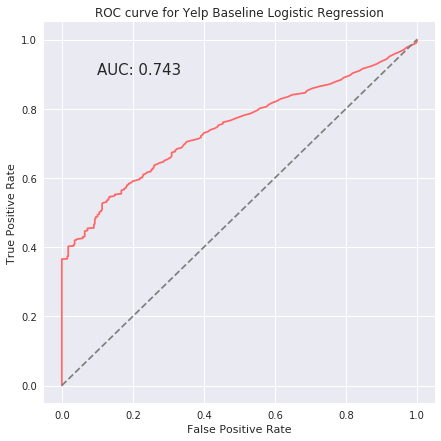

In [77]:
yelp_lrtpr, yelp_lrfpr, yelp_thresh_roc = roc_curve(np.array(baseline_ytest), 
                                                    yelp_baseline_lr.predict_proba(baseline_xtest)[:,1], 
                                                    pos_label='Pets')

plt.figure(figsize=(7,7))
plt.plot(yelp_lrfpr, yelp_lrtpr, color='#ff6666')
plt.plot([0,1], [0,1],linestyle='--',color='gray')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.1, 0.9,'AUC: {:0.3f}'.format(metrics.auc(yelp_lrfpr, yelp_lrtpr)), fontsize=15)
plt.title('ROC curve for Yelp Baseline Logistic Regression');

In [37]:
print('lr_baseline accuracy: {}'.format(np.mean(cross_val_score(yelp_lr, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.accuracy_score)))))
print('lr_baseline precision: {}'.format(np.mean(cross_val_score(yelp_lr, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.precision_score, average='macro')))))
print('lr_baseline recall: {}'.format(np.mean(cross_val_score(yelp_lr, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('lr_baseline F1: {}'.format(np.mean(cross_val_score(yelp_lr, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

lr_baseline accuracy: 0.4164041203532456
lr_baseline precision: 0.03633554446101944
lr_baseline recall: 0.046614820110589726
lr_baseline F1: 0.03337783742815275


Confusion matrix, without normalization


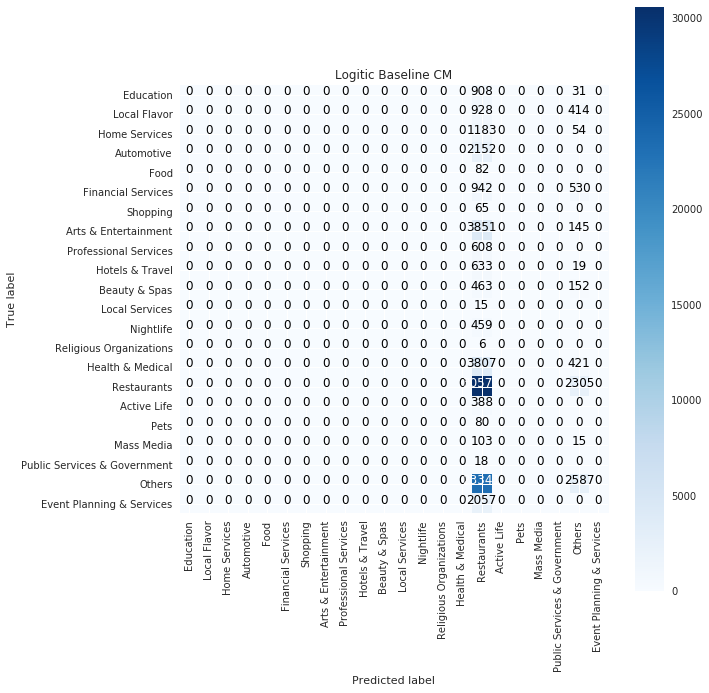

In [38]:
lr_baseline_cnf = confusion_matrix(baseline_ytest,yelp_baseline_lr_pred)
plot_confusion_matrix(lr_baseline_cnf, classes=list(set(yelp_df.primary_category.tolist())), title='Logitic Baseline CM')

#### <a id=6.3></a> 6.3 Expanding Logistic Regression with 5 original features

In [58]:
#define baseline model with 5 features
blv1_5x = yelp_df[['review_count', 'business_stars', 'review_count', 'stars', 'average_stars']]
blv1_5y = yelp_df.primary_category
baseline5f_xtrain, baseline5f_xtest, baseline5f_ytrain, baseline5f_ytest = train_test_split(blv1_5x, blv1_5y, 
                                                                                     test_size=0.2,random_state=42)

In [59]:
yelp_lr5f = LogisticRegression(penalty='l1', n_jobs=-1)
yelp_baseline5f_lr = yelp_lr5f.fit(baseline5f_xtrain, baseline5f_ytrain)
yelp_baseline5f_lr_pred = yelp_baseline5f_lr.predict(baseline5f_xtest)

In [65]:
print('baseline (5feature) logistic regression coefficient:')
list(zip(yelp_baseline5f_lr.classes_, yelp_baseline5f_lr.coef_))

baseline (5feature) logistic regression coefficient:


[('Active Life',
  array([-0.00041695,  0.40915227, -0.00123453,  0.03358224, -0.00058332])),
 ('Arts & Entertainment',
  array([ 0.0006686 , -0.10428405, -0.0002476 ,  0.01534683, -0.03342821])),
 ('Automotive', array([ -1.30075282e-05,  -2.51825123e-01,  -3.24264343e-04,
           3.15820068e-02,  -6.50703027e-02])),
 ('Beauty & Spas',
  array([-0.0018492 ,  0.7443064 , -0.00226179,  0.00514311,  0.07231422])),
 ('Education',
  array([-0.00884265,  0.53838344, -0.00984258,  0.01635752, -0.02453489])),
 ('Event Planning & Services',
  array([-0.00054693, -0.34854545,  0.00105365,  0.00682846, -0.06140667])),
 ('Financial Services',
  array([-0.02103686, -0.38871769, -0.02082882, -0.06094188,  0.01787242])),
 ('Food',
  array([ 0.00032301,  0.31325166, -0.00081191,  0.02421225, -0.04635099])),
 ('Health & Medical',
  array([-0.00773514,  0.45291925, -0.00911922,  0.02790619, -0.02630492])),
 ('Home Services',
  array([-0.00064588, -0.20541713, -0.00165378, -0.00429777, -0.01522821])),

In [61]:
print('lr_baseline (5e) recall: {}'.format(np.mean(cross_val_score(yelp_baseline5f_lr, blv1_5x, blv1_5y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('lr_baseline (5e) F1: {}'.format(np.mean(cross_val_score(yelp_baseline5f_lr, blv1_5x, blv1_5y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

lr_baseline recall: 0.046638016974622366
lr_baseline F1: 0.03324598892157309


#### <a id=6.4></a> 6.4 Expanding Logistic Regression with 5 feature engineered features

In [64]:
#5 feature baseline with engineering features
blv1_5xf = yelp_df[['review_count', 'number_of_vowels_in_business_name', 'business_name_length', 'total_business_hours', 'number_of_business_days']]
blv1_5yf = yelp_df.primary_category
baseline5fe_xtrain, baseline5fe_xtest, baseline5fe_ytrain, baseline5fe_ytest = train_test_split(blv1_5xf, blv1_5yf, 
                                                                                     test_size=0.2,random_state=42)

In [66]:
yelp_lr5fe = LogisticRegression(penalty='l1', n_jobs=-1)
yelp_baseline5fe_lr = yelp_lr5fe.fit(baseline5f_xtrain, baseline5fe_ytrain)
yelp_baseline5fe_lr_pred = yelp_baseline5fe_lr.predict(baseline5fe_xtest)

print('baseline logistic regression coefficient:')
list(zip(yelp_baseline5fe_lr.classes_, yelp_baseline5fe_lr.coef_))

baseline logistic regression coefficient:


[('Active Life',
  array([-0.00066743,  0.42881792, -0.00097868,  0.02717333,  0.00818715])),
 ('Arts & Entertainment',
  array([-0.00064906, -0.11967681,  0.0010696 ,  0.02263706, -0.04826279])),
 ('Automotive',
  array([-0.00082297, -0.28303326,  0.00048946,  0.04746349, -0.09817002])),
 ('Beauty & Spas',
  array([-0.00128817,  0.70103516, -0.00285535,  0.01946945,  0.0546135 ])),
 ('Education',
  array([-0.0067964 ,  0.52749706, -0.01191346,  0.02338741, -0.03501177])),
 ('Event Planning & Services',
  array([  2.82474075e-04,  -3.81497889e-01,   2.24589161e-04,
           1.85010815e-02,  -8.44086912e-02])),
 ('Financial Services',
  array([-0.01427335, -0.37821902, -0.02753435, -0.06726949,  0.03032888])),
 ('Food', array([ -5.18643083e-05,   3.07679214e-01,  -4.37489546e-04,
           2.14368535e-02,  -4.48151074e-02])),
 ('Health & Medical',
  array([-0.00681704,  0.39447699, -0.01010634,  0.04982989, -0.072903  ])),
 ('Home Services',
  array([-0.00120705, -0.16207262, -0.0010

In [67]:
print('lr_baseline recall: {}'.format(np.mean(cross_val_score(yelp_baseline5fe_lr, blv1_5x, blv1_5y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('lr_baseline F1: {}'.format(np.mean(cross_val_score(yelp_baseline5fe_lr, blv1_5x, blv1_5y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

lr_baseline recall: 0.0466222763977009
lr_baseline F1: 0.03325272592745795


#### <a id=6.5></a> 6.5 Expanding Logistic Regression with 10 features

In [72]:
#baseline + 10 features
blv1_10xf = yelp_df[['review_count', 'number_of_vowels_in_business_name', 'business_name_length', 'total_business_hours', 'number_of_business_days',
                    'tip_count', 'business_stars', 'review_count', 'stars', 'average_stars']]
blv1_10yf = yelp_df.primary_category
baseline10fe_xtrain, baseline10fe_xtest, baseline10fe_ytrain, baseline10fe_ytest = train_test_split(blv1_10xf, blv1_10yf, 
                                                                                     test_size=0.2,random_state=42)

In [73]:
yelp_lr10fe = LogisticRegression(penalty='l1', n_jobs=-1)
yelp_baseline10fe_lr = yelp_lr10fe.fit(baseline10fe_xtrain, baseline10fe_ytrain)
yelp_baseline10fe_lr_pred = yelp_baseline10fe_lr.predict(baseline10fe_xtest)

print('baseline logistic regression coefficient:')
list(zip(yelp_baseline10fe_lr.classes_, yelp_baseline10fe_lr.coef_))

baseline logistic regression coefficient:


[('Active Life',
  array([-0.0009269 , -0.04045102,  0.14300463,  0.00559555, -0.15853235,
          0.00235703,  0.50079206, -0.00120236,  0.02223028,  0.01743311])),
 ('Arts & Entertainment',
  array([-0.00041941,  0.02348229,  0.25317421, -0.01108189, -0.02687977,
          0.00030661,  0.04049635,  0.00079029,  0.01557846, -0.02664938])),
 ('Automotive',
  array([ 0.00063072,  0.0943294 ,  0.05273093,  0.00341568, -0.01733827,
         -0.00883679, -0.25980164,  0.0004977 ,  0.03338688, -0.06772749])),
 ('Beauty & Spas', array([ -2.74620488e-03,  -1.92705404e-01,   4.64829307e-01,
          -3.81812937e-03,   7.11334531e-02,  -2.75445891e-03,
           7.31907602e-01,  -8.82590320e-04,   2.73180573e-04,
           7.43808063e-02])),
 ('Education',
  array([-0.00984683,  0.2139185 , -0.09916701, -0.00994721, -0.04291301,
          0.01328206,  0.56639957, -0.01007663,  0.00462094, -0.0036695 ])),
 ('Event Planning & Services',
  array([  8.25352976e-05,   6.70723496e-02,   9.411997

In [75]:
print('lr_baseline_10f recall: {}'.format(np.mean(cross_val_score(yelp_baseline10fe_lr, blv1_10xf, blv1_10yf, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('lr_baseline_10f F1: {}'.format(np.mean(cross_val_score(yelp_baseline10fe_lr, blv1_10xf, blv1_10yf, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

lr_baseline_10f recall: 0.05554296159552214
lr_baseline_10f F1: 0.05087206549027982


#### <a =id=6.6></a> 6.6 Logistic Regression Model + all features

In [62]:
#define baseline model features and models
v2_x = yelp_df.drop(['business_name', 'primary_category', 'review_text', 'user_name', 'city', 'state'], axis = 1)
v2_y = yelp_df.primary_category
v2_xtrain, v2_xtest, v2_ytrain, v2_ytest = train_test_split(v2_x, v2_y, test_size=0.2,random_state=42)

In [63]:
yelp_lrv2 = LogisticRegression(n_jobs=-1)
yelp_v2_lr = yelp_lrv2.fit(v2_xtrain, v2_ytrain)
yelp_v2_lr_pred = yelp_v2_lr.predict(v2_xtest)

In [64]:
print('V2_all_feature logistic regression coefficient:')
list(zip(yelp_v2_lr.classes_, yelp_v2_lr.coef_))

V2_all_feature logistic regression coefficient:


[('Active Life', array([ -6.05862909e-02,  -6.28438848e-03,  -1.45522584e-02,
           7.68762173e-03,  -1.43575436e-02,  -5.79904897e-02,
          -1.36580889e-02,  -4.26142234e-03,  -2.25335784e-03,
          -1.10268681e-03,  -1.59192386e-04,   5.40004112e-05,
           6.49365117e-05,   5.43626954e-03,  -6.57802095e-02,
          -2.42654019e-03,   1.96782398e-03,  -2.05205266e-03,
          -2.42654019e-03,   7.29847129e-04,   1.26738221e-04,
           7.34625536e-04,   8.77453596e-05,   8.77453596e-05,
           6.32970193e-04,  -7.69163671e-04,  -4.21101826e-02,
          -2.55164710e-02,  -4.88503414e-02,  -9.85896107e-02,
          -1.79048874e-03])),
 ('Arts & Entertainment',
  array([ -6.37923927e-02,   1.31525335e-04,  -1.59725956e-02,
          -3.18766468e-04,   1.92298698e-03,  -6.14720582e-02,
          -1.88877010e-02,  -4.86698161e-03,  -3.83372798e-03,
          -8.11363488e-04,  -5.13021119e-05,   4.45164501e-05,
           2.18959061e-05,   4.03098940e-03,  -

In [79]:
print('lrv2_allfeature recall: {}'.format(np.mean(cross_val_score(yelp_lrv2, v2_x, v2_y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('lrv2_allfeature F1: {}'.format(np.mean(cross_val_score(yelp_lrv2, v2_x, v2_y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

lrv2_allfeature recall: 0.05049548518081975
lrv2_allfeature F1: 0.04288957728997459


Confusion matrix, without normalization


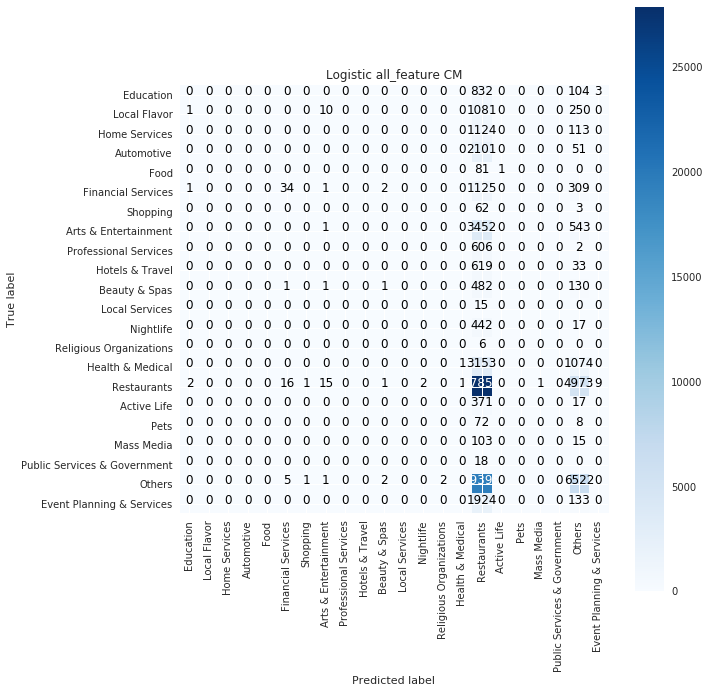

In [80]:
lr_v2_cnf = confusion_matrix(v2_ytest, yelp_v2_lr_pred)
plot_confusion_matrix(lr_v2_cnf, classes=list(set(yelp_df.primary_category.tolist())), title='Logistic all_feature CM')

#### <a id=6.7></a> 6.7 Baseline RF model (One feature)

In [39]:
blv1_x = yelp_df[['review_count']]
blv1_y = yelp_df.primary_category
baseline_xtrain, baseline_xtest, baseline_ytrain, baseline_ytest = train_test_split(blv1_x, blv1_y, 
                                                                                     test_size=0.2,random_state=42)

In [40]:
yelp_RF = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
yelp_baseline_RF = yelp_RF.fit(baseline_xtrain, baseline_ytrain)
yelp_baseline_RF_pred = yelp_baseline_RF.predict(baseline_xtest)

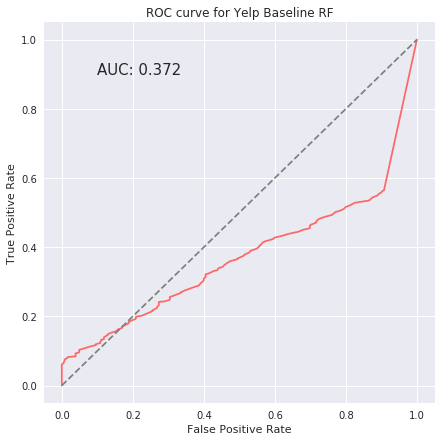

In [41]:
yelp_RFtpr, yelp_RFfpr, yelp_RFthresh_roc = roc_curve(np.array(baseline_ytest), 
                                                    yelp_baseline_RF.predict_proba(baseline_xtest)[:,1], 
                                                    pos_label='Pets')

plt.figure(figsize=(7,7))
plt.plot(yelp_RFfpr, yelp_RFtpr, color='#ff6666')
plt.plot([0,1], [0,1],linestyle='--',color='gray')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.1, 0.9,'AUC: {:0.3f}'.format(metrics.auc(yelp_RFfpr, yelp_RFtpr)), fontsize=15)
plt.title('ROC curve for Yelp Baseline RF');

In [42]:
print('RF_baseline accuracy: {}'.format(np.mean(cross_val_score(yelp_baseline_RF, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.accuracy_score)))))
print('RF_baseline precision: {}'.format(np.mean(cross_val_score(yelp_baseline_RF, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.precision_score, average='macro')))))
print('RF_baseline recall: {}'.format(np.mean(cross_val_score(yelp_baseline_RF, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('RF_baseline F1: {}'.format(np.mean(cross_val_score(yelp_baseline_RF, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

RF_baseline accuracy: 0.5052341127727137
RF_baseline precision: 0.3939749015086207
RF_baseline recall: 0.11873125482050151
RF_baseline F1: 0.14397267041638553


Confusion matrix, without normalization


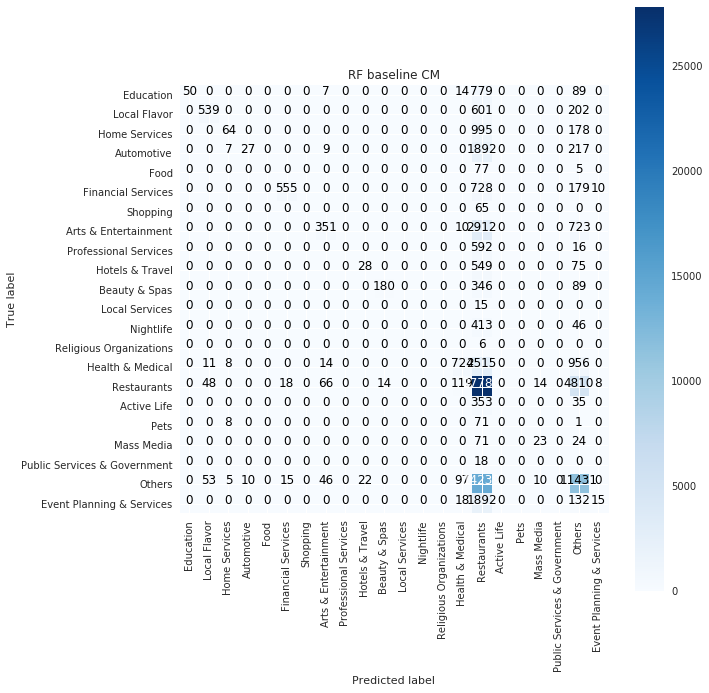

In [44]:
RF_baseline_cnf = confusion_matrix(baseline_ytest, yelp_baseline_RF_pred)
plot_confusion_matrix(RF_baseline_cnf, classes=list(set(yelp_df.primary_category.tolist())), title='RF baseline CM')

#### <a id=6.8></a> 6.8 Baseline xgBoost model (One feature)

In [50]:
blv1_x = yelp_df[['review_count']]
blv1_y = yelp_df.primary_category
baseline_xtrain, baseline_xtest, baseline_ytrain, baseline_ytest = train_test_split(blv1_x, blv1_y, 
                                                                                     test_size=0.2,random_state=42)
#baseline_xtrain, baseline_xval, baseline_ytrain, baseline_yval = train_test_split(baseline_xtrain, baseline_ytrain, 
#                                                                  test_size=0.25, random_state=2)

In [46]:
yelp_gbm = xgb.XGBClassifier(n_estimators=10000, max_depth=4, objective='multi:softmax',
                        learning_rate=.05, subsample=.8, min_child_weight=3,
                        colsample_bytree=.8, n_jobs=-1)
yelp_baseline_gbm = yelp_gbm.fit(baseline_xtrain, baseline_ytrain, 
                    eval_set=[(baseline_xtrain, baseline_ytrain),(baseline_xval, baseline_yval)],
                    eval_metric='merror', early_stopping_rounds=50, verbose=True)

[0]	validation_0-merror:0.555352	validation_1-merror:0.555285
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.553487	validation_1-merror:0.553357
[2]	validation_0-merror:0.554243	validation_1-merror:0.554605
[3]	validation_0-merror:0.552911	validation_1-merror:0.552777
[4]	validation_0-merror:0.55326	validation_1-merror:0.552449
[5]	validation_0-merror:0.551579	validation_1-merror:0.551201
[6]	validation_0-merror:0.547289	validation_1-merror:0.546323
[7]	validation_0-merror:0.547088	validation_1-merror:0.546084
[8]	validation_0-merror:0.547483	validation_1-merror:0.54655
[9]	validation_0-merror:0.546302	validation_1-merror:0.545428
[10]	validation_0-merror:0.546159	validation_1-merror:0.545227
[11]	validation_0-merror:0.546159	validation_1-merror:0.545227
[12]	validation_0-merror:0.546159	validation_1-merror:0.545227
[13]	validation_0-merror:0.546

[128]	validation_0-merror:0.524033	validation_1-merror:0.522475
[129]	validation_0-merror:0.524033	validation_1-merror:0.522475
[130]	validation_0-merror:0.524033	validation_1-merror:0.522475
[131]	validation_0-merror:0.524033	validation_1-merror:0.522475
[132]	validation_0-merror:0.523416	validation_1-merror:0.522046
[133]	validation_0-merror:0.523407	validation_1-merror:0.522033
[134]	validation_0-merror:0.522807	validation_1-merror:0.521491
[135]	validation_0-merror:0.521996	validation_1-merror:0.520786
[136]	validation_0-merror:0.520916	validation_1-merror:0.51984
[137]	validation_0-merror:0.520916	validation_1-merror:0.51984
[138]	validation_0-merror:0.521265	validation_1-merror:0.520155
[139]	validation_0-merror:0.521084	validation_1-merror:0.520004
[140]	validation_0-merror:0.520672	validation_1-merror:0.519815
[141]	validation_0-merror:0.520323	validation_1-merror:0.5195
[142]	validation_0-merror:0.520323	validation_1-merror:0.5195
[143]	validation_0-merror:0.520323	validation_

[257]	validation_0-merror:0.507513	validation_1-merror:0.506744
[258]	validation_0-merror:0.507277	validation_1-merror:0.506391
[259]	validation_0-merror:0.507277	validation_1-merror:0.506391
[260]	validation_0-merror:0.507277	validation_1-merror:0.506391
[261]	validation_0-merror:0.50716	validation_1-merror:0.50629
[262]	validation_0-merror:0.506424	validation_1-merror:0.505521
[263]	validation_0-merror:0.506424	validation_1-merror:0.505521
[264]	validation_0-merror:0.505798	validation_1-merror:0.504916
[265]	validation_0-merror:0.505798	validation_1-merror:0.504916
[266]	validation_0-merror:0.505798	validation_1-merror:0.504916
[267]	validation_0-merror:0.505798	validation_1-merror:0.504916
[268]	validation_0-merror:0.505798	validation_1-merror:0.504916
[269]	validation_0-merror:0.50421	validation_1-merror:0.50358
[270]	validation_0-merror:0.50421	validation_1-merror:0.50358
[271]	validation_0-merror:0.504038	validation_1-merror:0.503454
[272]	validation_0-merror:0.503815	validation_

[386]	validation_0-merror:0.494819	validation_1-merror:0.495538
[387]	validation_0-merror:0.494702	validation_1-merror:0.495412
[388]	validation_0-merror:0.494702	validation_1-merror:0.495412
[389]	validation_0-merror:0.494702	validation_1-merror:0.495412
[390]	validation_0-merror:0.494702	validation_1-merror:0.495412
[391]	validation_0-merror:0.494387	validation_1-merror:0.495034
[392]	validation_0-merror:0.494387	validation_1-merror:0.495034
[393]	validation_0-merror:0.494387	validation_1-merror:0.495034
[394]	validation_0-merror:0.494206	validation_1-merror:0.494845
[395]	validation_0-merror:0.494206	validation_1-merror:0.494845
[396]	validation_0-merror:0.494017	validation_1-merror:0.49458
[397]	validation_0-merror:0.494017	validation_1-merror:0.49458
[398]	validation_0-merror:0.494017	validation_1-merror:0.49458
[399]	validation_0-merror:0.494017	validation_1-merror:0.49458
[400]	validation_0-merror:0.493996	validation_1-merror:0.49463
[401]	validation_0-merror:0.493303	validation

[515]	validation_0-merror:0.48624	validation_1-merror:0.487509
[516]	validation_0-merror:0.486328	validation_1-merror:0.487786
[517]	validation_0-merror:0.486328	validation_1-merror:0.487786
[518]	validation_0-merror:0.486328	validation_1-merror:0.487786
[519]	validation_0-merror:0.486328	validation_1-merror:0.487786
[520]	validation_0-merror:0.486332	validation_1-merror:0.487962
[521]	validation_0-merror:0.486311	validation_1-merror:0.487861
[522]	validation_0-merror:0.486223	validation_1-merror:0.487584
[523]	validation_0-merror:0.486223	validation_1-merror:0.487584
[524]	validation_0-merror:0.486223	validation_1-merror:0.487584
[525]	validation_0-merror:0.486223	validation_1-merror:0.487584
[526]	validation_0-merror:0.486223	validation_1-merror:0.487584
[527]	validation_0-merror:0.486118	validation_1-merror:0.487509
[528]	validation_0-merror:0.485819	validation_1-merror:0.487206
[529]	validation_0-merror:0.485819	validation_1-merror:0.487206
[530]	validation_0-merror:0.485118	valida

[644]	validation_0-merror:0.480761	validation_1-merror:0.483021
[645]	validation_0-merror:0.480761	validation_1-merror:0.483021
[646]	validation_0-merror:0.480761	validation_1-merror:0.483021
[647]	validation_0-merror:0.480761	validation_1-merror:0.483021
[648]	validation_0-merror:0.480761	validation_1-merror:0.483021
[649]	validation_0-merror:0.480567	validation_1-merror:0.482845
[650]	validation_0-merror:0.480567	validation_1-merror:0.482845
[651]	validation_0-merror:0.480567	validation_1-merror:0.482845
[652]	validation_0-merror:0.480429	validation_1-merror:0.482756
[653]	validation_0-merror:0.480429	validation_1-merror:0.482756
[654]	validation_0-merror:0.480248	validation_1-merror:0.482542
[655]	validation_0-merror:0.480248	validation_1-merror:0.482542
[656]	validation_0-merror:0.480248	validation_1-merror:0.482542
[657]	validation_0-merror:0.480248	validation_1-merror:0.482542
[658]	validation_0-merror:0.48029	validation_1-merror:0.48263
[659]	validation_0-merror:0.480164	validat

[773]	validation_0-merror:0.477257	validation_1-merror:0.478874
[774]	validation_0-merror:0.477257	validation_1-merror:0.478874
[775]	validation_0-merror:0.477067	validation_1-merror:0.478685
[776]	validation_0-merror:0.477067	validation_1-merror:0.478685
[777]	validation_0-merror:0.477135	validation_1-merror:0.478773
[778]	validation_0-merror:0.477135	validation_1-merror:0.478773
[779]	validation_0-merror:0.477177	validation_1-merror:0.478862
[780]	validation_0-merror:0.477177	validation_1-merror:0.478862
[781]	validation_0-merror:0.477177	validation_1-merror:0.478862
[782]	validation_0-merror:0.477177	validation_1-merror:0.478862
[783]	validation_0-merror:0.477177	validation_1-merror:0.478862
[784]	validation_0-merror:0.477177	validation_1-merror:0.478862
[785]	validation_0-merror:0.477063	validation_1-merror:0.478735
[786]	validation_0-merror:0.477177	validation_1-merror:0.478862
[787]	validation_0-merror:0.477177	validation_1-merror:0.478862
[788]	validation_0-merror:0.477177	valid

In [48]:
f1_score(baseline_ytest, yelp_gbm.predict(baseline_xtest, ntree_limit=yelp_gbm.best_ntree_limit), average='macro')

0.16800406601375445

In [49]:
recall_score(baseline_ytest, yelp_gbm.predict(baseline_xtest, ntree_limit=yelp_gbm.best_ntree_limit), average='macro')

0.13716214636478927

In [ ]:
%%time
xgb_tuned_param=[{'learning_rate':[.01,.1,1,10,.001],'max_depth':[3,4,5,6,7,8]}]
clf = GridSearchCV(yelp_baseline_gbm, xgb_tuned_param, cv=3, scoring='f1')
clf.fit(baseline_xtrain, baseline_ytrain)

print("Best parameters set found on development set:")
print()
print(clf.best_estimator_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
             % (mean_score, scores.std() / 2, params))
    
#0.118 (+/-0.002) for {'learning_rate': 0.05, 'max_depth': 4, 'objective': 'multi:softmax'}
#0.155 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 8, 'objective': 'multi:softmax'}
#0.160 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 9, 'objective': 'multi:softmax'}

In [ ]:
print('RFv2_allfeature recall: {}'.format(np.mean(cross_val_score(yelp_baseline_gbm, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('RFv2_allfeature F1: {}'.format(np.mean(cross_val_score(yelp_baseline_gbm, blv1_x, blv1_y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

#### <a id=6.9></a> 6.9 RF model (All features)

In [56]:
#define baseline model features and models
v2_x = yelp_df.drop(['business_name', 'primary_category', 'review_text', 'user_name', 'city', 'state'], axis = 1)
v2_y = yelp_df.primary_category
v2_xtrain, v2_xtest, v2_ytrain, v2_ytest = train_test_split(v2_x, v2_y, test_size=0.2,random_state=42)

In [57]:
print('max feature is determined through taking sqrt of total number of features: {}'\
      .format(math.ceil(np.sqrt(len(v2_xtrain.columns)))))

max feature is determined through taking sqrt of total number of features: 6


In [58]:
yelpv2_RF = RandomForestClassifier(n_estimators = 1000, max_features = math.ceil(np.sqrt(len(v2_xtrain.columns))),
                                min_samples_leaf = 4, n_jobs=-1)
yelp_v2_RF = yelpv2_RF.fit(v2_xtrain, v2_ytrain)
yelp_v2_RF_pred = yelp_v2_RF.predict(v2_xtest)

In [55]:
print('RFv2_allfeature accuracy: {}'.format(np.mean(cross_val_score(yelpv2_RF, v2_x, v2_y, 
                                                           cv=3, scoring=make_scorer(metrics.accuracy_score)))))
print('RFv2_allfeature precision: {}'.format(np.mean(cross_val_score(yelpv2_RF, v2_x, v2_y, 
                                                           cv=3, scoring=make_scorer(metrics.precision_score, average='macro')))))
print('RFv2_allfeature recall: {}'.format(np.mean(cross_val_score(yelpv2_RF, v2_x, v2_y, 
                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('RFv2_allfeature F1: {}'.format(np.mean(cross_val_score(yelpv2_RF, v2_x, v2_y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

RFv2_allfeature accuracy: 0.6698984029705883
RFv2_allfeature precision: 0.8357079340800592
RFv2_allfeature recall: 0.21632851595464028
RFv2_allfeature F1: 0.2841622747615728


In [59]:
RFv2_feature_importances = sorted(zip(v2_x.columns,abs(yelp_v2_RF.feature_importances_)), key=lambda x: -x[1])[:25]
RFv2_feature_importances

[('review_count', 0.17652257762118742),
 ('tip_count', 0.14463566961862467),
 ('total_business_hours', 0.1233268482056456),
 ('checkins', 0.077000235761671129),
 ('number_of_vowels_in_business_name', 0.072995980187444603),
 ('business_stars', 0.055167904897120652),
 ('business_name_length', 0.045115225423987756),
 ('average_stars', 0.03655147977278287),
 ('user_review_counts', 0.034982321990329142),
 ('number_of_friends', 0.030592856170094766),
 ('u_useful', 0.023815983159461547),
 ('number_of_business_days', 0.017931025385217843),
 ('u_funny', 0.015498254833063692),
 ('r_review', 0.015028187465677023),
 ('u_cool', 0.013612026904005323),
 ('stars', 0.012948274874456246),
 ('u_fans', 0.012468193193323209),
 ('compliment_plain', 0.011295791013403169),
 ('compliment_note', 0.010787102542336518),
 ('is_open', 0.0097960094538823202),
 ('compliment_writer', 0.0086702223152370205),
 ('compliment_cool', 0.0086490071811572804),
 ('compliment_funny', 0.0086376172908800234),
 ('r_cool', 0.0066491

Text(0.5,0,'Features')

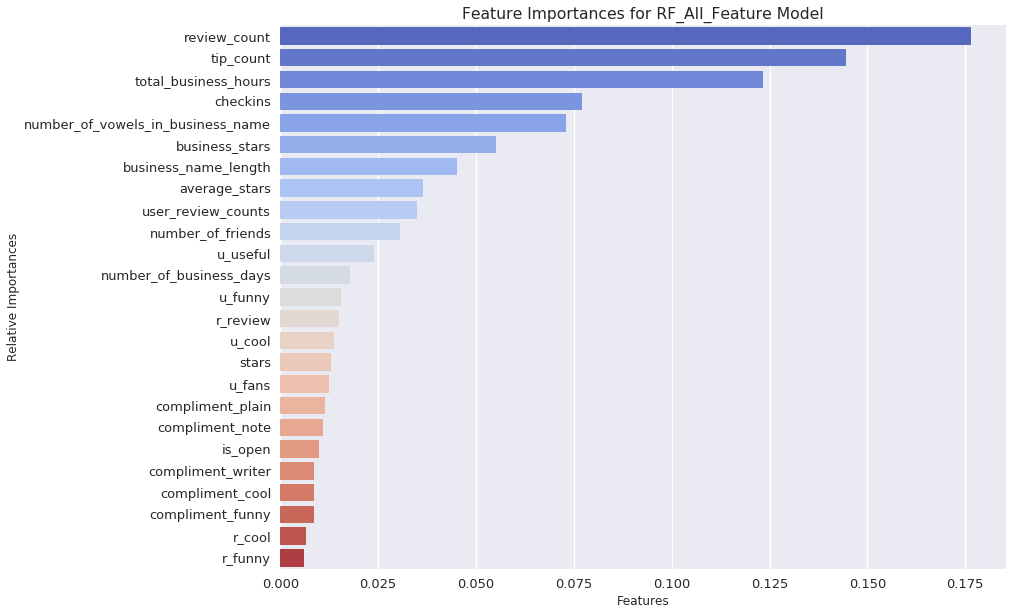

In [60]:
sns.set_context('talk')

plt.figure(figsize=(13,10))
features_, scores_ = zip(*RFv2_feature_importances)
sns.barplot(y=list(features_), x=list(scores_), palette='coolwarm')
plt.title("Feature Importances for RF_All_Feature Model")
plt.ylabel('Relative Importances', fontsize=12)
plt.xlabel('Features', fontsize=12)

Confusion matrix, without normalization


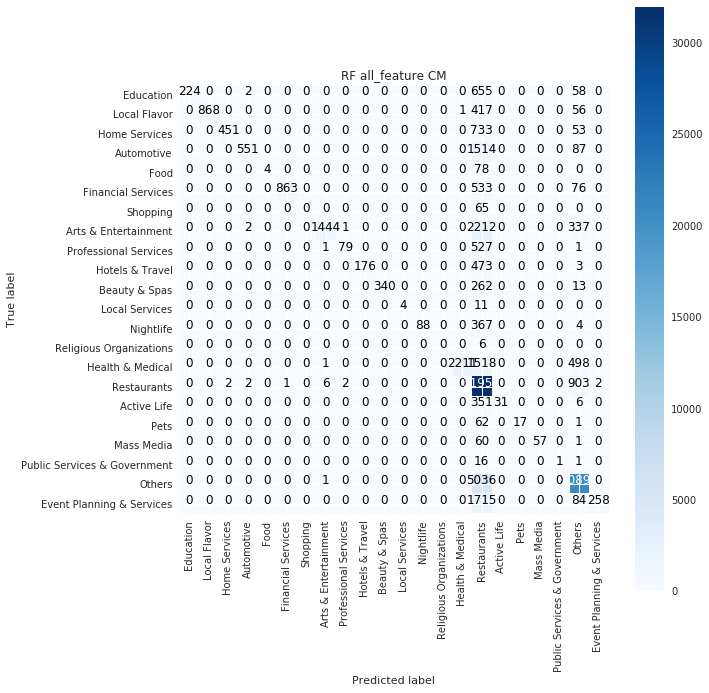

In [61]:
sns.set_context('notebook')
RF_v2_cnf = confusion_matrix(v2_ytest, yelp_v2_RF_pred)
plot_confusion_matrix(RF_v2_cnf, classes=list(set(yelp_df.primary_category.tolist())), title='RF all_feature CM')

#### <a id=6.10></a> 6.10 xgBoost model (All feature)

In [76]:
v2_x = yelp_df.drop(['business_name', 'primary_category', 'review_text', 'user_name', 'city', 'state', ], axis = 1)
v2_y = yelp_df.primary_category
v2_xtrain, v2_xtest, v2_ytrain, v2_ytest = train_test_split(v2_x, v2_y, test_size=0.2,random_state=42)
v2_xtrain, v2_xval, v2_ytrain, v2_yval = train_test_split(v2_xtrain, v2_ytrain, test_size=0.25, random_state=2)

In [77]:
v2_xtrain.drop(v2_xtrain.columns[15], axis=1, inplace=True)
v2_xtest.drop(v2_xtest.columns[15], axis=1, inplace=True)
v2_xval.drop(v2_xval.columns[15], axis=1, inplace=True)

In [ ]:
yelpv2_gbm = xgb.XGBClassifier(n_estimators=10000, max_depth=4, objective='multi:softmax',
                        learning_rate=0.1, subsample=.8, min_child_weight=3,
                        colsample_bytree=.8, n_jobs=-1)
yelp_v2_gbm = yelpv2_gbm.fit(v2_xtrain, v2_ytrain, 
                    eval_set=[(v2_xtrain, v2_ytrain),(v2_xval, v2_yval)],eval_metric='merror', early_stopping_rounds=30, verbose=True)

[0]	validation_0-merror:0.554155	validation_1-merror:0.554907
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.537512	validation_1-merror:0.537802
[2]	validation_0-merror:0.533117	validation_1-merror:0.533693
[3]	validation_0-merror:0.529899	validation_1-merror:0.530668
[4]	validation_0-merror:0.531323	validation_1-merror:0.532559
[5]	validation_0-merror:0.529764	validation_1-merror:0.530693
[6]	validation_0-merror:0.529084	validation_1-merror:0.529155
[7]	validation_0-merror:0.530054	validation_1-merror:0.529836
[8]	validation_0-merror:0.529378	validation_1-merror:0.529067
[9]	validation_0-merror:0.529949	validation_1-merror:0.529609
[10]	validation_0-merror:0.528311	validation_1-merror:0.527895
[11]	validation_0-merror:0.528248	validation_1-merror:0.527857
[12]	validation_0-merror:0.525672	validation_1-merror:0.525916
[13]	validation_0-merror:0.5

[128]	validation_0-merror:0.483114	validation_1-merror:0.484635
[129]	validation_0-merror:0.482765	validation_1-merror:0.484307
[130]	validation_0-merror:0.482336	validation_1-merror:0.484055
[131]	validation_0-merror:0.481996	validation_1-merror:0.483727
[132]	validation_0-merror:0.481534	validation_1-merror:0.483324
[133]	validation_0-merror:0.481353	validation_1-merror:0.483009
[134]	validation_0-merror:0.480996	validation_1-merror:0.482605
[135]	validation_0-merror:0.480777	validation_1-merror:0.482252
[136]	validation_0-merror:0.480399	validation_1-merror:0.481988
[137]	validation_0-merror:0.480362	validation_1-merror:0.482076
[138]	validation_0-merror:0.479979	validation_1-merror:0.481357
[139]	validation_0-merror:0.479698	validation_1-merror:0.480941
[140]	validation_0-merror:0.479391	validation_1-merror:0.480765
[141]	validation_0-merror:0.479214	validation_1-merror:0.480525
[142]	validation_0-merror:0.478857	validation_1-merror:0.479971
[143]	validation_0-merror:0.478925	valid

[257]	validation_0-merror:0.456231	validation_1-merror:0.46003
[258]	validation_0-merror:0.456236	validation_1-merror:0.460005
[259]	validation_0-merror:0.456168	validation_1-merror:0.459878
[260]	validation_0-merror:0.456059	validation_1-merror:0.459878
[261]	validation_0-merror:0.455942	validation_1-merror:0.459904
[262]	validation_0-merror:0.455681	validation_1-merror:0.459803
[263]	validation_0-merror:0.455694	validation_1-merror:0.45979
[264]	validation_0-merror:0.455458	validation_1-merror:0.459576
[265]	validation_0-merror:0.455324	validation_1-merror:0.459513
[266]	validation_0-merror:0.455244	validation_1-merror:0.459475
[267]	validation_0-merror:0.45511	validation_1-merror:0.459223
[268]	validation_0-merror:0.454874	validation_1-merror:0.458984
[269]	validation_0-merror:0.454673	validation_1-merror:0.458984
[270]	validation_0-merror:0.454563	validation_1-merror:0.458731
[271]	validation_0-merror:0.454412	validation_1-merror:0.458492
[272]	validation_0-merror:0.454358	validati

[386]	validation_0-merror:0.438244	validation_1-merror:0.444047
[387]	validation_0-merror:0.438118	validation_1-merror:0.444047
[388]	validation_0-merror:0.43782	validation_1-merror:0.443883
[389]	validation_0-merror:0.437895	validation_1-merror:0.443732
[390]	validation_0-merror:0.43753	validation_1-merror:0.443517
[391]	validation_0-merror:0.437383	validation_1-merror:0.443505
[392]	validation_0-merror:0.437089	validation_1-merror:0.443227
[393]	validation_0-merror:0.436967	validation_1-merror:0.443089
[394]	validation_0-merror:0.436845	validation_1-merror:0.44295
[395]	validation_0-merror:0.436828	validation_1-merror:0.442786
[396]	validation_0-merror:0.436669	validation_1-merror:0.442748
[397]	validation_0-merror:0.436635	validation_1-merror:0.442761
[398]	validation_0-merror:0.436543	validation_1-merror:0.442698
[399]	validation_0-merror:0.436341	validation_1-merror:0.442559
[400]	validation_0-merror:0.436118	validation_1-merror:0.442282
[401]	validation_0-merror:0.436009	validati

[515]	validation_0-merror:0.418072	validation_1-merror:0.427358
[516]	validation_0-merror:0.417938	validation_1-merror:0.427257
[517]	validation_0-merror:0.417807	validation_1-merror:0.427055
[518]	validation_0-merror:0.417681	validation_1-merror:0.426942
[519]	validation_0-merror:0.417589	validation_1-merror:0.426803
[520]	validation_0-merror:0.417328	validation_1-merror:0.426702
[521]	validation_0-merror:0.417228	validation_1-merror:0.426791
[522]	validation_0-merror:0.417097	validation_1-merror:0.426677
[523]	validation_0-merror:0.416963	validation_1-merror:0.426589
[524]	validation_0-merror:0.416723	validation_1-merror:0.426286
[525]	validation_0-merror:0.416648	validation_1-merror:0.426173
[526]	validation_0-merror:0.416421	validation_1-merror:0.426034
[527]	validation_0-merror:0.41637	validation_1-merror:0.425883
[528]	validation_0-merror:0.416228	validation_1-merror:0.425681
[529]	validation_0-merror:0.416047	validation_1-merror:0.425618
[530]	validation_0-merror:0.415946	valida

[644]	validation_0-merror:0.403001	validation_1-merror:0.414627
[645]	validation_0-merror:0.402976	validation_1-merror:0.414362
[646]	validation_0-merror:0.402938	validation_1-merror:0.414249
[647]	validation_0-merror:0.402799	validation_1-merror:0.414072
[648]	validation_0-merror:0.402808	validation_1-merror:0.414034
[649]	validation_0-merror:0.402736	validation_1-merror:0.413984
[650]	validation_0-merror:0.402534	validation_1-merror:0.413845
[651]	validation_0-merror:0.402539	validation_1-merror:0.413707
[652]	validation_0-merror:0.402379	validation_1-merror:0.413807
[653]	validation_0-merror:0.4024	validation_1-merror:0.413795
[654]	validation_0-merror:0.402219	validation_1-merror:0.413543
[655]	validation_0-merror:0.402114	validation_1-merror:0.413379
[656]	validation_0-merror:0.401917	validation_1-merror:0.413379
[657]	validation_0-merror:0.401602	validation_1-merror:0.413202
[658]	validation_0-merror:0.401434	validation_1-merror:0.413152
[659]	validation_0-merror:0.401442	validat

[773]	validation_0-merror:0.389866	validation_1-merror:0.403887
[774]	validation_0-merror:0.389589	validation_1-merror:0.403673
[775]	validation_0-merror:0.38953	validation_1-merror:0.403673
[776]	validation_0-merror:0.389425	validation_1-merror:0.403585
[777]	validation_0-merror:0.389358	validation_1-merror:0.403787
[778]	validation_0-merror:0.389165	validation_1-merror:0.403509
[779]	validation_0-merror:0.388997	validation_1-merror:0.403648
[780]	validation_0-merror:0.389018	validation_1-merror:0.403635
[781]	validation_0-merror:0.388925	validation_1-merror:0.40356
[782]	validation_0-merror:0.388799	validation_1-merror:0.403408
[783]	validation_0-merror:0.388682	validation_1-merror:0.403181
[784]	validation_0-merror:0.388631	validation_1-merror:0.403245
[785]	validation_0-merror:0.388366	validation_1-merror:0.403043
[786]	validation_0-merror:0.388383	validation_1-merror:0.402942
[787]	validation_0-merror:0.388316	validation_1-merror:0.402665
[788]	validation_0-merror:0.388341	validat

[902]	validation_0-merror:0.378972	validation_1-merror:0.39548
[903]	validation_0-merror:0.378858	validation_1-merror:0.395518
[904]	validation_0-merror:0.378665	validation_1-merror:0.395455
[905]	validation_0-merror:0.378602	validation_1-merror:0.395379
[906]	validation_0-merror:0.378585	validation_1-merror:0.39524
[907]	validation_0-merror:0.378476	validation_1-merror:0.395303
[908]	validation_0-merror:0.378404	validation_1-merror:0.395253
[909]	validation_0-merror:0.378358	validation_1-merror:0.395215
[910]	validation_0-merror:0.378278	validation_1-merror:0.395064
[911]	validation_0-merror:0.378156	validation_1-merror:0.395064
[912]	validation_0-merror:0.378085	validation_1-merror:0.39519
[913]	validation_0-merror:0.378072	validation_1-merror:0.395114
[914]	validation_0-merror:0.37803	validation_1-merror:0.395026
[915]	validation_0-merror:0.377833	validation_1-merror:0.395013
[916]	validation_0-merror:0.37782	validation_1-merror:0.394938
[917]	validation_0-merror:0.377762	validation

[1030]	validation_0-merror:0.368446	validation_1-merror:0.387829
[1031]	validation_0-merror:0.368455	validation_1-merror:0.387841
[1032]	validation_0-merror:0.368417	validation_1-merror:0.387778
[1033]	validation_0-merror:0.368278	validation_1-merror:0.387715
[1034]	validation_0-merror:0.368287	validation_1-merror:0.38774
[1035]	validation_0-merror:0.368152	validation_1-merror:0.387753
[1036]	validation_0-merror:0.368115	validation_1-merror:0.38764
[1037]	validation_0-merror:0.368068	validation_1-merror:0.387652
[1038]	validation_0-merror:0.367896	validation_1-merror:0.387388
[1039]	validation_0-merror:0.367804	validation_1-merror:0.387287
[1040]	validation_0-merror:0.367753	validation_1-merror:0.387249
[1041]	validation_0-merror:0.367682	validation_1-merror:0.387211
[1042]	validation_0-merror:0.367627	validation_1-merror:0.387173
[1043]	validation_0-merror:0.367514	validation_1-merror:0.387098
[1044]	validation_0-merror:0.367518	validation_1-merror:0.387186
[1045]	validation_0-merror:

[1157]	validation_0-merror:0.359148	validation_1-merror:0.380316
[1158]	validation_0-merror:0.359178	validation_1-merror:0.380215
[1159]	validation_0-merror:0.359064	validation_1-merror:0.380152
[1160]	validation_0-merror:0.358942	validation_1-merror:0.380102
[1161]	validation_0-merror:0.358783	validation_1-merror:0.379913
[1162]	validation_0-merror:0.358757	validation_1-merror:0.3799
[1163]	validation_0-merror:0.358661	validation_1-merror:0.379837
[1164]	validation_0-merror:0.358522	validation_1-merror:0.379686
[1165]	validation_0-merror:0.358489	validation_1-merror:0.379698
[1166]	validation_0-merror:0.358388	validation_1-merror:0.379686
[1167]	validation_0-merror:0.358358	validation_1-merror:0.379635
[1168]	validation_0-merror:0.3584	validation_1-merror:0.379585
[1169]	validation_0-merror:0.358274	validation_1-merror:0.379598
[1170]	validation_0-merror:0.358228	validation_1-merror:0.379585
[1171]	validation_0-merror:0.358094	validation_1-merror:0.379585
[1172]	validation_0-merror:0.

[1284]	validation_0-merror:0.350795	validation_1-merror:0.373888
[1285]	validation_0-merror:0.350665	validation_1-merror:0.373812
[1286]	validation_0-merror:0.350632	validation_1-merror:0.373825
[1287]	validation_0-merror:0.350531	validation_1-merror:0.373774
[1288]	validation_0-merror:0.350472	validation_1-merror:0.373825
[1289]	validation_0-merror:0.350337	validation_1-merror:0.373686
[1290]	validation_0-merror:0.35027	validation_1-merror:0.373648
[1291]	validation_0-merror:0.35019	validation_1-merror:0.373623
[1292]	validation_0-merror:0.350132	validation_1-merror:0.373535
[1293]	validation_0-merror:0.350094	validation_1-merror:0.373585
[1294]	validation_0-merror:0.350068	validation_1-merror:0.373648
[1295]	validation_0-merror:0.350035	validation_1-merror:0.373661
[1296]	validation_0-merror:0.349947	validation_1-merror:0.373711
[1297]	validation_0-merror:0.349884	validation_1-merror:0.373497
[1298]	validation_0-merror:0.349854	validation_1-merror:0.373585
[1299]	validation_0-merror:

[1411]	validation_0-merror:0.342489	validation_1-merror:0.367963
[1412]	validation_0-merror:0.342447	validation_1-merror:0.367951
[1413]	validation_0-merror:0.342413	validation_1-merror:0.367825
[1414]	validation_0-merror:0.342203	validation_1-merror:0.367547
[1415]	validation_0-merror:0.342102	validation_1-merror:0.367573
[1416]	validation_0-merror:0.342035	validation_1-merror:0.367585
[1417]	validation_0-merror:0.342031	validation_1-merror:0.367547
[1418]	validation_0-merror:0.341968	validation_1-merror:0.36761
[1419]	validation_0-merror:0.341909	validation_1-merror:0.36761
[1420]	validation_0-merror:0.341804	validation_1-merror:0.367648
[1421]	validation_0-merror:0.341724	validation_1-merror:0.367673
[1422]	validation_0-merror:0.341703	validation_1-merror:0.367661
[1423]	validation_0-merror:0.341669	validation_1-merror:0.367699
[1424]	validation_0-merror:0.34159	validation_1-merror:0.367598
[1425]	validation_0-merror:0.341522	validation_1-merror:0.367535
[1426]	validation_0-merror:0

[1538]	validation_0-merror:0.334317	validation_1-merror:0.362341
[1539]	validation_0-merror:0.334232	validation_1-merror:0.362304
[1540]	validation_0-merror:0.334085	validation_1-merror:0.361863
[1541]	validation_0-merror:0.334102	validation_1-merror:0.3619
[1542]	validation_0-merror:0.333917	validation_1-merror:0.361812
[1543]	validation_0-merror:0.333913	validation_1-merror:0.36185
[1544]	validation_0-merror:0.333758	validation_1-merror:0.361736
[1545]	validation_0-merror:0.333724	validation_1-merror:0.361699
[1546]	validation_0-merror:0.333598	validation_1-merror:0.361736
[1547]	validation_0-merror:0.333585	validation_1-merror:0.361661
[1548]	validation_0-merror:0.333552	validation_1-merror:0.361673
[1549]	validation_0-merror:0.333539	validation_1-merror:0.361774
[1550]	validation_0-merror:0.333468	validation_1-merror:0.361812
[1551]	validation_0-merror:0.333405	validation_1-merror:0.361762
[1552]	validation_0-merror:0.333396	validation_1-merror:0.361724
[1553]	validation_0-merror:0

[1665]	validation_0-merror:0.32722	validation_1-merror:0.357022
[1666]	validation_0-merror:0.327186	validation_1-merror:0.357035
[1667]	validation_0-merror:0.327081	validation_1-merror:0.356947
[1668]	validation_0-merror:0.327094	validation_1-merror:0.35701
[1669]	validation_0-merror:0.327052	validation_1-merror:0.356997
[1670]	validation_0-merror:0.326997	validation_1-merror:0.356947
[1671]	validation_0-merror:0.326943	validation_1-merror:0.356846
[1672]	validation_0-merror:0.326922	validation_1-merror:0.35672
[1673]	validation_0-merror:0.326842	validation_1-merror:0.356707
[1674]	validation_0-merror:0.326611	validation_1-merror:0.356682
[1675]	validation_0-merror:0.326543	validation_1-merror:0.356619
[1676]	validation_0-merror:0.326506	validation_1-merror:0.356732
[1677]	validation_0-merror:0.326506	validation_1-merror:0.356619
[1678]	validation_0-merror:0.326472	validation_1-merror:0.356631
[1679]	validation_0-merror:0.326476	validation_1-merror:0.356619
[1680]	validation_0-merror:0

[1792]	validation_0-merror:0.320203	validation_1-merror:0.35222
[1793]	validation_0-merror:0.320174	validation_1-merror:0.352283
[1794]	validation_0-merror:0.320119	validation_1-merror:0.352421
[1795]	validation_0-merror:0.320094	validation_1-merror:0.352358
[1796]	validation_0-merror:0.320039	validation_1-merror:0.352308
[1797]	validation_0-merror:0.319989	validation_1-merror:0.352232
[1798]	validation_0-merror:0.319959	validation_1-merror:0.352144
[1799]	validation_0-merror:0.319871	validation_1-merror:0.351892
[1800]	validation_0-merror:0.319787	validation_1-merror:0.351842
[1801]	validation_0-merror:0.319762	validation_1-merror:0.351905
[1802]	validation_0-merror:0.319716	validation_1-merror:0.351816
[1803]	validation_0-merror:0.319607	validation_1-merror:0.351678
[1804]	validation_0-merror:0.31951	validation_1-merror:0.351791
[1805]	validation_0-merror:0.31956	validation_1-merror:0.351753
[1806]	validation_0-merror:0.319485	validation_1-merror:0.351716
[1807]	validation_0-merror:0

[1919]	validation_0-merror:0.313749	validation_1-merror:0.348111
[1920]	validation_0-merror:0.313741	validation_1-merror:0.348073
[1921]	validation_0-merror:0.313623	validation_1-merror:0.348073
[1922]	validation_0-merror:0.313619	validation_1-merror:0.348035
[1923]	validation_0-merror:0.313523	validation_1-merror:0.347972
[1924]	validation_0-merror:0.313451	validation_1-merror:0.347972
[1925]	validation_0-merror:0.313409	validation_1-merror:0.347972
[1926]	validation_0-merror:0.313388	validation_1-merror:0.347909
[1927]	validation_0-merror:0.313401	validation_1-merror:0.347921
[1928]	validation_0-merror:0.313334	validation_1-merror:0.347921
[1929]	validation_0-merror:0.313321	validation_1-merror:0.347846
[1930]	validation_0-merror:0.313304	validation_1-merror:0.347884
[1931]	validation_0-merror:0.313207	validation_1-merror:0.347783
[1932]	validation_0-merror:0.313111	validation_1-merror:0.347833
[1933]	validation_0-merror:0.313031	validation_1-merror:0.347732
[1934]	validation_0-merro

[2046]	validation_0-merror:0.307951	validation_1-merror:0.34409
[2047]	validation_0-merror:0.307934	validation_1-merror:0.344115
[2048]	validation_0-merror:0.307846	validation_1-merror:0.344077
[2049]	validation_0-merror:0.307783	validation_1-merror:0.343989
[2050]	validation_0-merror:0.307699	validation_1-merror:0.343976
[2051]	validation_0-merror:0.307636	validation_1-merror:0.3439
[2052]	validation_0-merror:0.307657	validation_1-merror:0.343812
[2053]	validation_0-merror:0.307632	validation_1-merror:0.343737
[2054]	validation_0-merror:0.307573	validation_1-merror:0.343661
[2055]	validation_0-merror:0.307447	validation_1-merror:0.343598
[2056]	validation_0-merror:0.307413	validation_1-merror:0.343661
[2057]	validation_0-merror:0.307388	validation_1-merror:0.343674
[2058]	validation_0-merror:0.307384	validation_1-merror:0.343774
[2059]	validation_0-merror:0.3073	validation_1-merror:0.343787
[2060]	validation_0-merror:0.307283	validation_1-merror:0.343837
[2061]	validation_0-merror:0.3

[2173]	validation_0-merror:0.302624	validation_1-merror:0.340837
[2174]	validation_0-merror:0.302514	validation_1-merror:0.340598
[2175]	validation_0-merror:0.302397	validation_1-merror:0.340396
[2176]	validation_0-merror:0.302292	validation_1-merror:0.340321
[2177]	validation_0-merror:0.302279	validation_1-merror:0.340195
[2178]	validation_0-merror:0.302199	validation_1-merror:0.340169
[2179]	validation_0-merror:0.302212	validation_1-merror:0.340119
[2180]	validation_0-merror:0.302081	validation_1-merror:0.340069
[2181]	validation_0-merror:0.30209	validation_1-merror:0.339943
[2182]	validation_0-merror:0.302023	validation_1-merror:0.340031
[2183]	validation_0-merror:0.302044	validation_1-merror:0.340018
[2184]	validation_0-merror:0.301968	validation_1-merror:0.339943
[2185]	validation_0-merror:0.301955	validation_1-merror:0.339955
[2186]	validation_0-merror:0.301918	validation_1-merror:0.340106
[2187]	validation_0-merror:0.301905	validation_1-merror:0.33998
[2188]	validation_0-merror:

[2300]	validation_0-merror:0.297287	validation_1-merror:0.337043
[2301]	validation_0-merror:0.297241	validation_1-merror:0.337056
[2302]	validation_0-merror:0.29714	validation_1-merror:0.337006
[2303]	validation_0-merror:0.297229	validation_1-merror:0.336993
[2304]	validation_0-merror:0.29722	validation_1-merror:0.336917
[2305]	validation_0-merror:0.297115	validation_1-merror:0.33693
[2306]	validation_0-merror:0.297098	validation_1-merror:0.336905
[2307]	validation_0-merror:0.297111	validation_1-merror:0.336867
[2308]	validation_0-merror:0.297044	validation_1-merror:0.336842
[2309]	validation_0-merror:0.297018	validation_1-merror:0.336753
[2310]	validation_0-merror:0.296989	validation_1-merror:0.336741
[2311]	validation_0-merror:0.296947	validation_1-merror:0.33659
[2312]	validation_0-merror:0.29688	validation_1-merror:0.336653
[2313]	validation_0-merror:0.296796	validation_1-merror:0.336602
[2314]	validation_0-merror:0.296678	validation_1-merror:0.336552
[2315]	validation_0-merror:0.2

[2427]	validation_0-merror:0.292103	validation_1-merror:0.333753
[2428]	validation_0-merror:0.291989	validation_1-merror:0.333728
[2429]	validation_0-merror:0.291968	validation_1-merror:0.333728
[2430]	validation_0-merror:0.291905	validation_1-merror:0.333728
[2431]	validation_0-merror:0.291909	validation_1-merror:0.333665
[2432]	validation_0-merror:0.291876	validation_1-merror:0.333627
[2433]	validation_0-merror:0.2918	validation_1-merror:0.333577
[2434]	validation_0-merror:0.291758	validation_1-merror:0.333678
[2435]	validation_0-merror:0.291724	validation_1-merror:0.33369
[2436]	validation_0-merror:0.291674	validation_1-merror:0.333678
[2437]	validation_0-merror:0.29164	validation_1-merror:0.33369
[2438]	validation_0-merror:0.291573	validation_1-merror:0.333577
[2439]	validation_0-merror:0.291552	validation_1-merror:0.333514
[2440]	validation_0-merror:0.291531	validation_1-merror:0.333514
[2441]	validation_0-merror:0.291464	validation_1-merror:0.333539
[2442]	validation_0-merror:0.2

[2554]	validation_0-merror:0.287506	validation_1-merror:0.330464
[2555]	validation_0-merror:0.287443	validation_1-merror:0.330577
[2556]	validation_0-merror:0.287359	validation_1-merror:0.330602
[2557]	validation_0-merror:0.287384	validation_1-merror:0.330577
[2558]	validation_0-merror:0.287355	validation_1-merror:0.330514
[2559]	validation_0-merror:0.287351	validation_1-merror:0.330489
[2560]	validation_0-merror:0.287325	validation_1-merror:0.330401
[2561]	validation_0-merror:0.287288	validation_1-merror:0.330489
[2562]	validation_0-merror:0.287279	validation_1-merror:0.330514
[2563]	validation_0-merror:0.28725	validation_1-merror:0.330438
[2564]	validation_0-merror:0.28722	validation_1-merror:0.330438
[2565]	validation_0-merror:0.287245	validation_1-merror:0.330552
[2566]	validation_0-merror:0.28717	validation_1-merror:0.330438
[2567]	validation_0-merror:0.287107	validation_1-merror:0.330338
[2568]	validation_0-merror:0.287069	validation_1-merror:0.330413
[2569]	validation_0-merror:0

[2681]	validation_0-merror:0.282893	validation_1-merror:0.327993
[2682]	validation_0-merror:0.282872	validation_1-merror:0.32788
[2683]	validation_0-merror:0.282788	validation_1-merror:0.327905
[2684]	validation_0-merror:0.282729	validation_1-merror:0.32788
[2685]	validation_0-merror:0.282678	validation_1-merror:0.327854
[2686]	validation_0-merror:0.282661	validation_1-merror:0.327804
[2687]	validation_0-merror:0.282615	validation_1-merror:0.327754
[2688]	validation_0-merror:0.282624	validation_1-merror:0.327703
[2689]	validation_0-merror:0.282565	validation_1-merror:0.327703
[2690]	validation_0-merror:0.282456	validation_1-merror:0.327703
[2691]	validation_0-merror:0.282456	validation_1-merror:0.327716
[2692]	validation_0-merror:0.282401	validation_1-merror:0.327577
[2693]	validation_0-merror:0.282388	validation_1-merror:0.327539
[2694]	validation_0-merror:0.282355	validation_1-merror:0.327476
[2695]	validation_0-merror:0.28233	validation_1-merror:0.327564
[2696]	validation_0-merror:0

[2808]	validation_0-merror:0.278393	validation_1-merror:0.325573
[2809]	validation_0-merror:0.278351	validation_1-merror:0.325522
[2810]	validation_0-merror:0.278304	validation_1-merror:0.325585
[2811]	validation_0-merror:0.278279	validation_1-merror:0.32556
[2812]	validation_0-merror:0.278258	validation_1-merror:0.325497
[2813]	validation_0-merror:0.278204	validation_1-merror:0.325497
[2814]	validation_0-merror:0.278199	validation_1-merror:0.325497
[2815]	validation_0-merror:0.278157	validation_1-merror:0.325522
[2816]	validation_0-merror:0.278145	validation_1-merror:0.325447
[2817]	validation_0-merror:0.27809	validation_1-merror:0.325434
[2818]	validation_0-merror:0.278027	validation_1-merror:0.325497
[2819]	validation_0-merror:0.278002	validation_1-merror:0.325459
[2820]	validation_0-merror:0.277981	validation_1-merror:0.325396
[2821]	validation_0-merror:0.277943	validation_1-merror:0.325346
[2822]	validation_0-merror:0.277968	validation_1-merror:0.325434
[2823]	validation_0-merror:

[2935]	validation_0-merror:0.274141	validation_1-merror:0.323027
[2936]	validation_0-merror:0.274132	validation_1-merror:0.323027
[2937]	validation_0-merror:0.274111	validation_1-merror:0.322926
[2938]	validation_0-merror:0.274065	validation_1-merror:0.322888
[2939]	validation_0-merror:0.274048	validation_1-merror:0.322875
[2940]	validation_0-merror:0.274023	validation_1-merror:0.322863
[2941]	validation_0-merror:0.273993	validation_1-merror:0.322838
[2942]	validation_0-merror:0.273935	validation_1-merror:0.322787
[2943]	validation_0-merror:0.273872	validation_1-merror:0.322623
[2944]	validation_0-merror:0.273851	validation_1-merror:0.322586
[2945]	validation_0-merror:0.27375	validation_1-merror:0.322686
[2946]	validation_0-merror:0.273687	validation_1-merror:0.322724
[2947]	validation_0-merror:0.273611	validation_1-merror:0.322724
[2948]	validation_0-merror:0.27359	validation_1-merror:0.322661
[2949]	validation_0-merror:0.273565	validation_1-merror:0.322623
[2950]	validation_0-merror:

[3062]	validation_0-merror:0.270057	validation_1-merror:0.32077
[3063]	validation_0-merror:0.269981	validation_1-merror:0.320657
[3064]	validation_0-merror:0.269964	validation_1-merror:0.320594
[3065]	validation_0-merror:0.269905	validation_1-merror:0.320657
[3066]	validation_0-merror:0.269905	validation_1-merror:0.320682
[3067]	validation_0-merror:0.269859	validation_1-merror:0.320607
[3068]	validation_0-merror:0.26983	validation_1-merror:0.320556
[3069]	validation_0-merror:0.269783	validation_1-merror:0.320644
[3070]	validation_0-merror:0.269767	validation_1-merror:0.320682
[3071]	validation_0-merror:0.269741	validation_1-merror:0.320556
[3072]	validation_0-merror:0.269725	validation_1-merror:0.320632
[3073]	validation_0-merror:0.269733	validation_1-merror:0.320619
[3074]	validation_0-merror:0.269662	validation_1-merror:0.320632
[3075]	validation_0-merror:0.269565	validation_1-merror:0.320443
[3076]	validation_0-merror:0.26951	validation_1-merror:0.320455
[3077]	validation_0-merror:0

[3189]	validation_0-merror:0.26601	validation_1-merror:0.318842
[3190]	validation_0-merror:0.265964	validation_1-merror:0.318754
[3191]	validation_0-merror:0.265897	validation_1-merror:0.318678
[3192]	validation_0-merror:0.265922	validation_1-merror:0.318615
[3193]	validation_0-merror:0.265884	validation_1-merror:0.318489
[3194]	validation_0-merror:0.265779	validation_1-merror:0.318388
[3195]	validation_0-merror:0.265712	validation_1-merror:0.318275
[3196]	validation_0-merror:0.265674	validation_1-merror:0.318249
[3197]	validation_0-merror:0.265662	validation_1-merror:0.318237
[3198]	validation_0-merror:0.26559	validation_1-merror:0.318237
[3199]	validation_0-merror:0.265557	validation_1-merror:0.318123
[3200]	validation_0-merror:0.265485	validation_1-merror:0.318149
[3201]	validation_0-merror:0.265435	validation_1-merror:0.318073
[3202]	validation_0-merror:0.265376	validation_1-merror:0.318123
[3203]	validation_0-merror:0.265368	validation_1-merror:0.318073
[3204]	validation_0-merror:

[3316]	validation_0-merror:0.261741	validation_1-merror:0.316913
[3317]	validation_0-merror:0.261683	validation_1-merror:0.316863
[3318]	validation_0-merror:0.261632	validation_1-merror:0.3168
[3319]	validation_0-merror:0.261632	validation_1-merror:0.316875
[3320]	validation_0-merror:0.261607	validation_1-merror:0.316812
[3321]	validation_0-merror:0.261565	validation_1-merror:0.316762
[3322]	validation_0-merror:0.261544	validation_1-merror:0.316686
[3323]	validation_0-merror:0.261548	validation_1-merror:0.316737
[3324]	validation_0-merror:0.261527	validation_1-merror:0.316787
[3325]	validation_0-merror:0.261498	validation_1-merror:0.316724
[3326]	validation_0-merror:0.26146	validation_1-merror:0.316737
[3327]	validation_0-merror:0.26138	validation_1-merror:0.316573
[3328]	validation_0-merror:0.261393	validation_1-merror:0.316485
[3329]	validation_0-merror:0.261405	validation_1-merror:0.316485
[3330]	validation_0-merror:0.261355	validation_1-merror:0.316384
[3331]	validation_0-merror:0.

[3443]	validation_0-merror:0.25767	validation_1-merror:0.31477
[3444]	validation_0-merror:0.257687	validation_1-merror:0.314707
[3445]	validation_0-merror:0.257687	validation_1-merror:0.314682
[3446]	validation_0-merror:0.257712	validation_1-merror:0.314619
[3447]	validation_0-merror:0.257599	validation_1-merror:0.314657
[3448]	validation_0-merror:0.257649	validation_1-merror:0.31467
[3449]	validation_0-merror:0.257645	validation_1-merror:0.31467
[3450]	validation_0-merror:0.257704	validation_1-merror:0.31467
[3451]	validation_0-merror:0.257607	validation_1-merror:0.31467
[3452]	validation_0-merror:0.257607	validation_1-merror:0.314657
[3453]	validation_0-merror:0.257552	validation_1-merror:0.314644
[3454]	validation_0-merror:0.257502	validation_1-merror:0.314556
[3455]	validation_0-merror:0.257439	validation_1-merror:0.314594
[3456]	validation_0-merror:0.257372	validation_1-merror:0.314531
[3457]	validation_0-merror:0.257443	validation_1-merror:0.314531
[3458]	validation_0-merror:0.25

[3570]	validation_0-merror:0.254074	validation_1-merror:0.312401
[3571]	validation_0-merror:0.254065	validation_1-merror:0.312338
[3572]	validation_0-merror:0.254019	validation_1-merror:0.312313
[3573]	validation_0-merror:0.254006	validation_1-merror:0.312388
[3574]	validation_0-merror:0.253989	validation_1-merror:0.312325
[3575]	validation_0-merror:0.253981	validation_1-merror:0.312287
[3576]	validation_0-merror:0.25391	validation_1-merror:0.312376
[3577]	validation_0-merror:0.25391	validation_1-merror:0.31235
[3578]	validation_0-merror:0.253876	validation_1-merror:0.312413
[3579]	validation_0-merror:0.253905	validation_1-merror:0.312401
[3580]	validation_0-merror:0.253838	validation_1-merror:0.312388
[3581]	validation_0-merror:0.253813	validation_1-merror:0.312439
[3582]	validation_0-merror:0.253767	validation_1-merror:0.312401
[3583]	validation_0-merror:0.253763	validation_1-merror:0.312439
[3584]	validation_0-merror:0.253746	validation_1-merror:0.312426
[3585]	validation_0-merror:0

[3697]	validation_0-merror:0.249897	validation_1-merror:0.310447
[3698]	validation_0-merror:0.249847	validation_1-merror:0.310334
[3699]	validation_0-merror:0.249834	validation_1-merror:0.310409
[3700]	validation_0-merror:0.249838	validation_1-merror:0.310334
[3701]	validation_0-merror:0.249712	validation_1-merror:0.310233
[3702]	validation_0-merror:0.249641	validation_1-merror:0.310182
[3703]	validation_0-merror:0.249653	validation_1-merror:0.310258
[3704]	validation_0-merror:0.249662	validation_1-merror:0.310245
[3705]	validation_0-merror:0.249599	validation_1-merror:0.31017
[3706]	validation_0-merror:0.249553	validation_1-merror:0.310107
[3707]	validation_0-merror:0.249557	validation_1-merror:0.310107
[3708]	validation_0-merror:0.249532	validation_1-merror:0.310094
[3709]	validation_0-merror:0.249511	validation_1-merror:0.310081
[3710]	validation_0-merror:0.249468	validation_1-merror:0.310044
[3711]	validation_0-merror:0.249414	validation_1-merror:0.309955
[3712]	validation_0-merror

[3824]	validation_0-merror:0.24625	validation_1-merror:0.308455
[3825]	validation_0-merror:0.246204	validation_1-merror:0.308493
[3826]	validation_0-merror:0.246153	validation_1-merror:0.308443
[3827]	validation_0-merror:0.246137	validation_1-merror:0.30843
[3828]	validation_0-merror:0.24617	validation_1-merror:0.308443
[3829]	validation_0-merror:0.246166	validation_1-merror:0.308405
[3830]	validation_0-merror:0.24617	validation_1-merror:0.30843
[3831]	validation_0-merror:0.246145	validation_1-merror:0.308367
[3832]	validation_0-merror:0.246111	validation_1-merror:0.308292
[3833]	validation_0-merror:0.24609	validation_1-merror:0.308241
[3834]	validation_0-merror:0.246057	validation_1-merror:0.308266
[3835]	validation_0-merror:0.246053	validation_1-merror:0.308254
[3836]	validation_0-merror:0.245998	validation_1-merror:0.308228
[3837]	validation_0-merror:0.245964	validation_1-merror:0.308203
[3838]	validation_0-merror:0.245897	validation_1-merror:0.308102
[3839]	validation_0-merror:0.24

[3951]	validation_0-merror:0.2427	validation_1-merror:0.306451
[3952]	validation_0-merror:0.242641	validation_1-merror:0.306476
[3953]	validation_0-merror:0.242586	validation_1-merror:0.306514
[3954]	validation_0-merror:0.242578	validation_1-merror:0.306577
[3955]	validation_0-merror:0.242515	validation_1-merror:0.306577
[3956]	validation_0-merror:0.242477	validation_1-merror:0.3063
[3957]	validation_0-merror:0.242435	validation_1-merror:0.306237
[3958]	validation_0-merror:0.242389	validation_1-merror:0.306237
[3959]	validation_0-merror:0.242355	validation_1-merror:0.306237
[3960]	validation_0-merror:0.242347	validation_1-merror:0.306161
[3961]	validation_0-merror:0.2423	validation_1-merror:0.306199
[3962]	validation_0-merror:0.242292	validation_1-merror:0.306123
[3963]	validation_0-merror:0.242279	validation_1-merror:0.306123
[3964]	validation_0-merror:0.242229	validation_1-merror:0.30606
[3965]	validation_0-merror:0.242221	validation_1-merror:0.305985
[3966]	validation_0-merror:0.242

[4078]	validation_0-merror:0.239338	validation_1-merror:0.304724
[4079]	validation_0-merror:0.239263	validation_1-merror:0.304712
[4080]	validation_0-merror:0.239271	validation_1-merror:0.304699
[4081]	validation_0-merror:0.239191	validation_1-merror:0.304699
[4082]	validation_0-merror:0.239162	validation_1-merror:0.304611
[4083]	validation_0-merror:0.239124	validation_1-merror:0.30456
[4084]	validation_0-merror:0.239086	validation_1-merror:0.304586
[4085]	validation_0-merror:0.239053	validation_1-merror:0.304598
[4086]	validation_0-merror:0.238994	validation_1-merror:0.304611
[4087]	validation_0-merror:0.238948	validation_1-merror:0.304485
[4088]	validation_0-merror:0.238948	validation_1-merror:0.304434
[4089]	validation_0-merror:0.238973	validation_1-merror:0.304497
[4090]	validation_0-merror:0.238956	validation_1-merror:0.30451
[4091]	validation_0-merror:0.238935	validation_1-merror:0.304472
[4092]	validation_0-merror:0.23888	validation_1-merror:0.304422
[4093]	validation_0-merror:0

[4205]	validation_0-merror:0.235893	validation_1-merror:0.30335
[4206]	validation_0-merror:0.235822	validation_1-merror:0.303325
[4207]	validation_0-merror:0.235838	validation_1-merror:0.303325
[4208]	validation_0-merror:0.235876	validation_1-merror:0.303287
[4209]	validation_0-merror:0.235826	validation_1-merror:0.303262
[4210]	validation_0-merror:0.235805	validation_1-merror:0.30325
[4211]	validation_0-merror:0.235767	validation_1-merror:0.30325
[4212]	validation_0-merror:0.235792	validation_1-merror:0.3033
[4213]	validation_0-merror:0.235784	validation_1-merror:0.303376
[4214]	validation_0-merror:0.2357	validation_1-merror:0.303363
[4215]	validation_0-merror:0.235687	validation_1-merror:0.303313
[4216]	validation_0-merror:0.235645	validation_1-merror:0.303313
[4217]	validation_0-merror:0.235632	validation_1-merror:0.303325
[4218]	validation_0-merror:0.23562	validation_1-merror:0.303313
[4219]	validation_0-merror:0.235582	validation_1-merror:0.303262
[4220]	validation_0-merror:0.2355

[4332]	validation_0-merror:0.232515	validation_1-merror:0.301863
[4333]	validation_0-merror:0.232485	validation_1-merror:0.301888
[4334]	validation_0-merror:0.232422	validation_1-merror:0.301825
[4335]	validation_0-merror:0.232435	validation_1-merror:0.301775
[4336]	validation_0-merror:0.232443	validation_1-merror:0.3018
[4337]	validation_0-merror:0.232406	validation_1-merror:0.301838
[4338]	validation_0-merror:0.232401	validation_1-merror:0.301863
[4339]	validation_0-merror:0.232397	validation_1-merror:0.30185
[4340]	validation_0-merror:0.232368	validation_1-merror:0.301926
[4341]	validation_0-merror:0.232343	validation_1-merror:0.301888
[4342]	validation_0-merror:0.232288	validation_1-merror:0.301876
[4343]	validation_0-merror:0.232259	validation_1-merror:0.301876
[4344]	validation_0-merror:0.232242	validation_1-merror:0.301838
[4345]	validation_0-merror:0.232191	validation_1-merror:0.301813
[4346]	validation_0-merror:0.232162	validation_1-merror:0.301674
[4347]	validation_0-merror:0

[4459]	validation_0-merror:0.229322	validation_1-merror:0.300313
[4460]	validation_0-merror:0.22928	validation_1-merror:0.300338
[4461]	validation_0-merror:0.229242	validation_1-merror:0.300287
[4462]	validation_0-merror:0.229212	validation_1-merror:0.30035
[4463]	validation_0-merror:0.229183	validation_1-merror:0.300325
[4464]	validation_0-merror:0.229179	validation_1-merror:0.300325
[4465]	validation_0-merror:0.229196	validation_1-merror:0.300401
[4466]	validation_0-merror:0.229154	validation_1-merror:0.300388
[4467]	validation_0-merror:0.229179	validation_1-merror:0.300325
[4468]	validation_0-merror:0.229149	validation_1-merror:0.300338
[4469]	validation_0-merror:0.229116	validation_1-merror:0.300388
[4470]	validation_0-merror:0.229116	validation_1-merror:0.300376
[4471]	validation_0-merror:0.229078	validation_1-merror:0.300388
[4472]	validation_0-merror:0.229095	validation_1-merror:0.300287
[4473]	validation_0-merror:0.229053	validation_1-merror:0.300224
[4474]	validation_0-merror:

[4586]	validation_0-merror:0.225998	validation_1-merror:0.298397
[4587]	validation_0-merror:0.225948	validation_1-merror:0.298409
[4588]	validation_0-merror:0.225922	validation_1-merror:0.298371
[4589]	validation_0-merror:0.225973	validation_1-merror:0.298346
[4590]	validation_0-merror:0.225931	validation_1-merror:0.298434
[4591]	validation_0-merror:0.225906	validation_1-merror:0.298409
[4592]	validation_0-merror:0.225897	validation_1-merror:0.298397
[4593]	validation_0-merror:0.225927	validation_1-merror:0.298409
[4594]	validation_0-merror:0.225847	validation_1-merror:0.298434
[4595]	validation_0-merror:0.225851	validation_1-merror:0.298447
[4596]	validation_0-merror:0.225826	validation_1-merror:0.298472
[4597]	validation_0-merror:0.225771	validation_1-merror:0.298409
[4598]	validation_0-merror:0.22575	validation_1-merror:0.298434
[4599]	validation_0-merror:0.225742	validation_1-merror:0.298334
[4600]	validation_0-merror:0.225746	validation_1-merror:0.298346
[4601]	validation_0-merror

[4713]	validation_0-merror:0.22288	validation_1-merror:0.297061
[4714]	validation_0-merror:0.222859	validation_1-merror:0.297136
[4715]	validation_0-merror:0.222851	validation_1-merror:0.297086
[4716]	validation_0-merror:0.222813	validation_1-merror:0.297086
[4717]	validation_0-merror:0.222771	validation_1-merror:0.29701
[4718]	validation_0-merror:0.222771	validation_1-merror:0.296998
[4719]	validation_0-merror:0.222759	validation_1-merror:0.296998
[4720]	validation_0-merror:0.222733	validation_1-merror:0.297061
[4721]	validation_0-merror:0.22275	validation_1-merror:0.297111
[4722]	validation_0-merror:0.222712	validation_1-merror:0.297035
[4723]	validation_0-merror:0.222675	validation_1-merror:0.296998
[4724]	validation_0-merror:0.22267	validation_1-merror:0.296909
[4725]	validation_0-merror:0.222612	validation_1-merror:0.296884
[4726]	validation_0-merror:0.222612	validation_1-merror:0.296947
[4727]	validation_0-merror:0.222561	validation_1-merror:0.296972
[4728]	validation_0-merror:0.

[4840]	validation_0-merror:0.219927	validation_1-merror:0.295523
[4841]	validation_0-merror:0.219906	validation_1-merror:0.29546
[4842]	validation_0-merror:0.219948	validation_1-merror:0.295371
[4843]	validation_0-merror:0.219923	validation_1-merror:0.295422
[4844]	validation_0-merror:0.219885	validation_1-merror:0.295523
[4845]	validation_0-merror:0.219834	validation_1-merror:0.29546
[4846]	validation_0-merror:0.21978	validation_1-merror:0.29551
[4847]	validation_0-merror:0.219788	validation_1-merror:0.29546
[4848]	validation_0-merror:0.21978	validation_1-merror:0.29546
[4849]	validation_0-merror:0.219738	validation_1-merror:0.295346
[4850]	validation_0-merror:0.219712	validation_1-merror:0.295321
[4851]	validation_0-merror:0.219645	validation_1-merror:0.295409
[4852]	validation_0-merror:0.219649	validation_1-merror:0.295371
[4853]	validation_0-merror:0.219662	validation_1-merror:0.295359
[4854]	validation_0-merror:0.219654	validation_1-merror:0.295472
[4855]	validation_0-merror:0.219

[4967]	validation_0-merror:0.217028	validation_1-merror:0.294426
[4968]	validation_0-merror:0.217015	validation_1-merror:0.294313
[4969]	validation_0-merror:0.216973	validation_1-merror:0.294313
[4970]	validation_0-merror:0.217015	validation_1-merror:0.294325
[4971]	validation_0-merror:0.216994	validation_1-merror:0.294262
[4972]	validation_0-merror:0.216969	validation_1-merror:0.294187
[4973]	validation_0-merror:0.216994	validation_1-merror:0.294199
[4974]	validation_0-merror:0.216935	validation_1-merror:0.294313
[4975]	validation_0-merror:0.216906	validation_1-merror:0.294287
[4976]	validation_0-merror:0.216906	validation_1-merror:0.294275
[4977]	validation_0-merror:0.216809	validation_1-merror:0.294187
[4978]	validation_0-merror:0.21675	validation_1-merror:0.294187
[4979]	validation_0-merror:0.216801	validation_1-merror:0.294262
[4980]	validation_0-merror:0.216801	validation_1-merror:0.294212
[4981]	validation_0-merror:0.216771	validation_1-merror:0.294174
[4982]	validation_0-merror

[5094]	validation_0-merror:0.214133	validation_1-merror:0.292964
[5095]	validation_0-merror:0.214078	validation_1-merror:0.292964
[5096]	validation_0-merror:0.214036	validation_1-merror:0.292888
[5097]	validation_0-merror:0.21407	validation_1-merror:0.29285
[5098]	validation_0-merror:0.214023	validation_1-merror:0.29285
[5099]	validation_0-merror:0.214036	validation_1-merror:0.292775
[5100]	validation_0-merror:0.213994	validation_1-merror:0.292762
[5101]	validation_0-merror:0.214007	validation_1-merror:0.292762
[5102]	validation_0-merror:0.213927	validation_1-merror:0.292712
[5103]	validation_0-merror:0.213906	validation_1-merror:0.292787
[5104]	validation_0-merror:0.213868	validation_1-merror:0.292825
[5105]	validation_0-merror:0.213855	validation_1-merror:0.292737
[5106]	validation_0-merror:0.213839	validation_1-merror:0.292724
[5107]	validation_0-merror:0.213771	validation_1-merror:0.292687
[5108]	validation_0-merror:0.213801	validation_1-merror:0.292661
[5109]	validation_0-merror:0

[5221]	validation_0-merror:0.211255	validation_1-merror:0.291363
[5222]	validation_0-merror:0.21125	validation_1-merror:0.29135
[5223]	validation_0-merror:0.211229	validation_1-merror:0.29135
[5224]	validation_0-merror:0.211208	validation_1-merror:0.291363
[5225]	validation_0-merror:0.211141	validation_1-merror:0.291275
[5226]	validation_0-merror:0.211128	validation_1-merror:0.2913
[5227]	validation_0-merror:0.211141	validation_1-merror:0.291262
[5228]	validation_0-merror:0.211107	validation_1-merror:0.291313
[5229]	validation_0-merror:0.21104	validation_1-merror:0.291363
[5230]	validation_0-merror:0.210952	validation_1-merror:0.291287
[5231]	validation_0-merror:0.210986	validation_1-merror:0.2913
[5232]	validation_0-merror:0.210935	validation_1-merror:0.291275
[5233]	validation_0-merror:0.210885	validation_1-merror:0.291174
[5234]	validation_0-merror:0.210906	validation_1-merror:0.291161
[5235]	validation_0-merror:0.210893	validation_1-merror:0.291136
[5236]	validation_0-merror:0.2108

[5348]	validation_0-merror:0.208843	validation_1-merror:0.289989
[5349]	validation_0-merror:0.208839	validation_1-merror:0.289964
[5350]	validation_0-merror:0.208813	validation_1-merror:0.289989
[5351]	validation_0-merror:0.208813	validation_1-merror:0.289863
[5352]	validation_0-merror:0.208801	validation_1-merror:0.289888
[5353]	validation_0-merror:0.208788	validation_1-merror:0.289964
[5354]	validation_0-merror:0.208767	validation_1-merror:0.289926
[5355]	validation_0-merror:0.208767	validation_1-merror:0.289964
[5356]	validation_0-merror:0.208729	validation_1-merror:0.289926
[5357]	validation_0-merror:0.208729	validation_1-merror:0.289863
[5358]	validation_0-merror:0.208717	validation_1-merror:0.289876
[5359]	validation_0-merror:0.208717	validation_1-merror:0.289926
[5360]	validation_0-merror:0.208708	validation_1-merror:0.289888
[5361]	validation_0-merror:0.208662	validation_1-merror:0.289989
[5362]	validation_0-merror:0.208658	validation_1-merror:0.290065
[5363]	validation_0-merro

[5475]	validation_0-merror:0.206271	validation_1-merror:0.289107
[5476]	validation_0-merror:0.20625	validation_1-merror:0.289119
[5477]	validation_0-merror:0.206213	validation_1-merror:0.289056
[5478]	validation_0-merror:0.206187	validation_1-merror:0.289044
[5479]	validation_0-merror:0.206192	validation_1-merror:0.289069
[5480]	validation_0-merror:0.206133	validation_1-merror:0.289069
[5481]	validation_0-merror:0.206099	validation_1-merror:0.289031
[5482]	validation_0-merror:0.206103	validation_1-merror:0.289019
[5483]	validation_0-merror:0.206053	validation_1-merror:0.288943
[5484]	validation_0-merror:0.206074	validation_1-merror:0.28893
[5485]	validation_0-merror:0.206078	validation_1-merror:0.288893
[5486]	validation_0-merror:0.206095	validation_1-merror:0.288893
[5487]	validation_0-merror:0.206032	validation_1-merror:0.288905
[5488]	validation_0-merror:0.205986	validation_1-merror:0.28883
[5489]	validation_0-merror:0.205998	validation_1-merror:0.288817
[5490]	validation_0-merror:0

[5602]	validation_0-merror:0.203465	validation_1-merror:0.287909
[5603]	validation_0-merror:0.203452	validation_1-merror:0.287771
[5604]	validation_0-merror:0.203431	validation_1-merror:0.287821
[5605]	validation_0-merror:0.203427	validation_1-merror:0.287834
[5606]	validation_0-merror:0.203364	validation_1-merror:0.287846
[5607]	validation_0-merror:0.203326	validation_1-merror:0.287821
[5608]	validation_0-merror:0.203339	validation_1-merror:0.287846
[5609]	validation_0-merror:0.203318	validation_1-merror:0.287922
[5610]	validation_0-merror:0.203313	validation_1-merror:0.287859
[5611]	validation_0-merror:0.20328	validation_1-merror:0.287846
[5612]	validation_0-merror:0.203284	validation_1-merror:0.287834
[5613]	validation_0-merror:0.203276	validation_1-merror:0.287796
[5614]	validation_0-merror:0.203326	validation_1-merror:0.287771
[5615]	validation_0-merror:0.203301	validation_1-merror:0.287708
[5616]	validation_0-merror:0.203305	validation_1-merror:0.287708
[5617]	validation_0-merror

[5729]	validation_0-merror:0.200981	validation_1-merror:0.286712
[5730]	validation_0-merror:0.200969	validation_1-merror:0.286636
[5731]	validation_0-merror:0.200944	validation_1-merror:0.286561
[5732]	validation_0-merror:0.200956	validation_1-merror:0.286561
[5733]	validation_0-merror:0.200897	validation_1-merror:0.286598
[5734]	validation_0-merror:0.200906	validation_1-merror:0.286649
[5735]	validation_0-merror:0.200868	validation_1-merror:0.286561
[5736]	validation_0-merror:0.200906	validation_1-merror:0.286498
[5737]	validation_0-merror:0.200944	validation_1-merror:0.286535
[5738]	validation_0-merror:0.200893	validation_1-merror:0.286624
[5739]	validation_0-merror:0.200851	validation_1-merror:0.286649
[5740]	validation_0-merror:0.200847	validation_1-merror:0.286548
[5741]	validation_0-merror:0.200813	validation_1-merror:0.286523
[5742]	validation_0-merror:0.200839	validation_1-merror:0.286561
[5743]	validation_0-merror:0.200822	validation_1-merror:0.286598
[5744]	validation_0-merro

[5856]	validation_0-merror:0.198603	validation_1-merror:0.285464
[5857]	validation_0-merror:0.198608	validation_1-merror:0.285451
[5858]	validation_0-merror:0.198595	validation_1-merror:0.285426
[5859]	validation_0-merror:0.198566	validation_1-merror:0.285401
[5860]	validation_0-merror:0.198503	validation_1-merror:0.285401
[5861]	validation_0-merror:0.198498	validation_1-merror:0.285325
[5862]	validation_0-merror:0.198473	validation_1-merror:0.285388
[5863]	validation_0-merror:0.198435	validation_1-merror:0.285363
[5864]	validation_0-merror:0.198406	validation_1-merror:0.285401
[5865]	validation_0-merror:0.198389	validation_1-merror:0.285351
[5866]	validation_0-merror:0.198385	validation_1-merror:0.285388
[5867]	validation_0-merror:0.198381	validation_1-merror:0.285401
[5868]	validation_0-merror:0.198343	validation_1-merror:0.285376
[5869]	validation_0-merror:0.198301	validation_1-merror:0.285262
[5870]	validation_0-merror:0.19825	validation_1-merror:0.285338
[5871]	validation_0-merror

[5983]	validation_0-merror:0.196259	validation_1-merror:0.284178
[5984]	validation_0-merror:0.196267	validation_1-merror:0.284203
[5985]	validation_0-merror:0.196238	validation_1-merror:0.284166
[5986]	validation_0-merror:0.196208	validation_1-merror:0.284052
[5987]	validation_0-merror:0.196133	validation_1-merror:0.284065
[5988]	validation_0-merror:0.196141	validation_1-merror:0.284002
[5989]	validation_0-merror:0.196112	validation_1-merror:0.283989
[5990]	validation_0-merror:0.196082	validation_1-merror:0.28404
[5991]	validation_0-merror:0.196045	validation_1-merror:0.283901
[5992]	validation_0-merror:0.196078	validation_1-merror:0.283888
[5993]	validation_0-merror:0.196028	validation_1-merror:0.283851
[5994]	validation_0-merror:0.196003	validation_1-merror:0.283813
[5995]	validation_0-merror:0.195961	validation_1-merror:0.283788
[5996]	validation_0-merror:0.195965	validation_1-merror:0.28375
[5997]	validation_0-merror:0.195965	validation_1-merror:0.2838
[5998]	validation_0-merror:0.

[6110]	validation_0-merror:0.193948	validation_1-merror:0.28288
[6111]	validation_0-merror:0.193898	validation_1-merror:0.282918
[6112]	validation_0-merror:0.193839	validation_1-merror:0.282918
[6113]	validation_0-merror:0.193826	validation_1-merror:0.28288
[6114]	validation_0-merror:0.193788	validation_1-merror:0.28283
[6115]	validation_0-merror:0.193771	validation_1-merror:0.282817
[6116]	validation_0-merror:0.193776	validation_1-merror:0.282842
[6117]	validation_0-merror:0.193742	validation_1-merror:0.282893
[6118]	validation_0-merror:0.193759	validation_1-merror:0.282905
[6119]	validation_0-merror:0.193797	validation_1-merror:0.282918
[6120]	validation_0-merror:0.193713	validation_1-merror:0.282893
[6121]	validation_0-merror:0.193738	validation_1-merror:0.28288
[6122]	validation_0-merror:0.193717	validation_1-merror:0.282817
[6123]	validation_0-merror:0.193692	validation_1-merror:0.28283
[6124]	validation_0-merror:0.193645	validation_1-merror:0.28283
[6125]	validation_0-merror:0.19

[6237]	validation_0-merror:0.191776	validation_1-merror:0.282388
[6238]	validation_0-merror:0.191725	validation_1-merror:0.282414
[6239]	validation_0-merror:0.19175	validation_1-merror:0.282388
[6240]	validation_0-merror:0.191759	validation_1-merror:0.282351
[6241]	validation_0-merror:0.191738	validation_1-merror:0.282225
[6242]	validation_0-merror:0.191704	validation_1-merror:0.282275
[6243]	validation_0-merror:0.191692	validation_1-merror:0.28225
[6244]	validation_0-merror:0.191629	validation_1-merror:0.282262
[6245]	validation_0-merror:0.191587	validation_1-merror:0.282237
[6246]	validation_0-merror:0.191603	validation_1-merror:0.28225
[6247]	validation_0-merror:0.191578	validation_1-merror:0.282225
[6248]	validation_0-merror:0.191574	validation_1-merror:0.28225
[6249]	validation_0-merror:0.19154	validation_1-merror:0.282313
[6250]	validation_0-merror:0.191511	validation_1-merror:0.282288
[6251]	validation_0-merror:0.19149	validation_1-merror:0.282225
[6252]	validation_0-merror:0.19

[6364]	validation_0-merror:0.189469	validation_1-merror:0.281569
[6365]	validation_0-merror:0.189456	validation_1-merror:0.281607
[6366]	validation_0-merror:0.189511	validation_1-merror:0.281506
[6367]	validation_0-merror:0.189444	validation_1-merror:0.281393
[6368]	validation_0-merror:0.18941	validation_1-merror:0.28143
[6369]	validation_0-merror:0.189406	validation_1-merror:0.28143
[6370]	validation_0-merror:0.189385	validation_1-merror:0.281304
[6371]	validation_0-merror:0.189305	validation_1-merror:0.281216
[6372]	validation_0-merror:0.189267	validation_1-merror:0.281241
[6373]	validation_0-merror:0.189339	validation_1-merror:0.281304
[6374]	validation_0-merror:0.189335	validation_1-merror:0.281342
[6375]	validation_0-merror:0.189288	validation_1-merror:0.28133
[6376]	validation_0-merror:0.189301	validation_1-merror:0.281292
[6377]	validation_0-merror:0.189284	validation_1-merror:0.281292
[6378]	validation_0-merror:0.189267	validation_1-merror:0.281267
[6379]	validation_0-merror:0.

[6491]	validation_0-merror:0.187343	validation_1-merror:0.28022
[6492]	validation_0-merror:0.187297	validation_1-merror:0.280157
[6493]	validation_0-merror:0.187288	validation_1-merror:0.280145
[6494]	validation_0-merror:0.187276	validation_1-merror:0.28017
[6495]	validation_0-merror:0.18728	validation_1-merror:0.280233
[6496]	validation_0-merror:0.187318	validation_1-merror:0.280132
[6497]	validation_0-merror:0.187288	validation_1-merror:0.280094
[6498]	validation_0-merror:0.187272	validation_1-merror:0.280107
[6499]	validation_0-merror:0.187209	validation_1-merror:0.280208
[6500]	validation_0-merror:0.187171	validation_1-merror:0.280145
[6501]	validation_0-merror:0.187154	validation_1-merror:0.28017
[6502]	validation_0-merror:0.187129	validation_1-merror:0.280233
[6503]	validation_0-merror:0.187112	validation_1-merror:0.280183
[6504]	validation_0-merror:0.187133	validation_1-merror:0.280195
[6505]	validation_0-merror:0.187158	validation_1-merror:0.280233
[6506]	validation_0-merror:0.

[6618]	validation_0-merror:0.185078	validation_1-merror:0.279048
[6619]	validation_0-merror:0.185108	validation_1-merror:0.279023
[6620]	validation_0-merror:0.185061	validation_1-merror:0.278985
[6621]	validation_0-merror:0.185087	validation_1-merror:0.278972
[6622]	validation_0-merror:0.185032	validation_1-merror:0.278947
[6623]	validation_0-merror:0.185028	validation_1-merror:0.278884
[6624]	validation_0-merror:0.185049	validation_1-merror:0.278859
[6625]	validation_0-merror:0.185032	validation_1-merror:0.278846
[6626]	validation_0-merror:0.18504	validation_1-merror:0.278809
[6627]	validation_0-merror:0.185024	validation_1-merror:0.278872
[6628]	validation_0-merror:0.184956	validation_1-merror:0.278884
[6629]	validation_0-merror:0.184986	validation_1-merror:0.278809
[6630]	validation_0-merror:0.184935	validation_1-merror:0.278846
[6631]	validation_0-merror:0.184902	validation_1-merror:0.278846
[6632]	validation_0-merror:0.184935	validation_1-merror:0.278821
[6633]	validation_0-merror

[6745]	validation_0-merror:0.183049	validation_1-merror:0.277914
[6746]	validation_0-merror:0.183032	validation_1-merror:0.277926
[6747]	validation_0-merror:0.182998	validation_1-merror:0.278002
[6748]	validation_0-merror:0.183049	validation_1-merror:0.277926
[6749]	validation_0-merror:0.183032	validation_1-merror:0.277989
[6750]	validation_0-merror:0.182994	validation_1-merror:0.277926
[6751]	validation_0-merror:0.182973	validation_1-merror:0.277888
[6752]	validation_0-merror:0.182948	validation_1-merror:0.277926
[6753]	validation_0-merror:0.182935	validation_1-merror:0.277863
[6754]	validation_0-merror:0.182931	validation_1-merror:0.277813
[6755]	validation_0-merror:0.182927	validation_1-merror:0.277825
[6756]	validation_0-merror:0.182919	validation_1-merror:0.277825
[6757]	validation_0-merror:0.182893	validation_1-merror:0.277825
[6758]	validation_0-merror:0.182877	validation_1-merror:0.277737
[6759]	validation_0-merror:0.182826	validation_1-merror:0.27775
[6760]	validation_0-merror

[6872]	validation_0-merror:0.181007	validation_1-merror:0.276804
[6873]	validation_0-merror:0.180931	validation_1-merror:0.276842
[6874]	validation_0-merror:0.180893	validation_1-merror:0.276792
[6875]	validation_0-merror:0.180889	validation_1-merror:0.276842
[6876]	validation_0-merror:0.180847	validation_1-merror:0.276754
[6877]	validation_0-merror:0.180839	validation_1-merror:0.276779
[6878]	validation_0-merror:0.180801	validation_1-merror:0.276767
[6879]	validation_0-merror:0.180788	validation_1-merror:0.276804
[6880]	validation_0-merror:0.180793	validation_1-merror:0.27688
[6881]	validation_0-merror:0.180797	validation_1-merror:0.276817
[6882]	validation_0-merror:0.180868	validation_1-merror:0.276804
[6883]	validation_0-merror:0.180902	validation_1-merror:0.276792
[6884]	validation_0-merror:0.18086	validation_1-merror:0.276792
[6885]	validation_0-merror:0.180843	validation_1-merror:0.27683
[6886]	validation_0-merror:0.180835	validation_1-merror:0.276792
[6887]	validation_0-merror:0

[6999]	validation_0-merror:0.178725	validation_1-merror:0.275909
[7000]	validation_0-merror:0.178696	validation_1-merror:0.275998
[7001]	validation_0-merror:0.178717	validation_1-merror:0.27596
[7002]	validation_0-merror:0.178688	validation_1-merror:0.27596
[7003]	validation_0-merror:0.178683	validation_1-merror:0.275884
[7004]	validation_0-merror:0.178654	validation_1-merror:0.275884
[7005]	validation_0-merror:0.178662	validation_1-merror:0.275909
[7006]	validation_0-merror:0.178612	validation_1-merror:0.275897
[7007]	validation_0-merror:0.178595	validation_1-merror:0.275922
[7008]	validation_0-merror:0.178574	validation_1-merror:0.275935
[7009]	validation_0-merror:0.178511	validation_1-merror:0.275897
[7010]	validation_0-merror:0.178557	validation_1-merror:0.275897
[7011]	validation_0-merror:0.178482	validation_1-merror:0.275884
[7012]	validation_0-merror:0.17844	validation_1-merror:0.275897
[7013]	validation_0-merror:0.178389	validation_1-merror:0.275922
[7014]	validation_0-merror:0

[7126]	validation_0-merror:0.176721	validation_1-merror:0.275204
[7127]	validation_0-merror:0.176688	validation_1-merror:0.275141
[7128]	validation_0-merror:0.176667	validation_1-merror:0.275078
[7129]	validation_0-merror:0.176675	validation_1-merror:0.275103
[7130]	validation_0-merror:0.176616	validation_1-merror:0.275078
[7131]	validation_0-merror:0.17662	validation_1-merror:0.275027
[7132]	validation_0-merror:0.176583	validation_1-merror:0.275002
[7133]	validation_0-merror:0.176549	validation_1-merror:0.275014
[7134]	validation_0-merror:0.176541	validation_1-merror:0.274964
[7135]	validation_0-merror:0.176494	validation_1-merror:0.274977
[7136]	validation_0-merror:0.176456	validation_1-merror:0.274901
[7137]	validation_0-merror:0.176469	validation_1-merror:0.274901
[7138]	validation_0-merror:0.176452	validation_1-merror:0.274863
[7139]	validation_0-merror:0.176486	validation_1-merror:0.274926
[7140]	validation_0-merror:0.176469	validation_1-merror:0.274926
[7141]	validation_0-merror

[7253]	validation_0-merror:0.174646	validation_1-merror:0.274283
[7254]	validation_0-merror:0.174637	validation_1-merror:0.274296
[7255]	validation_0-merror:0.174629	validation_1-merror:0.274346
[7256]	validation_0-merror:0.174604	validation_1-merror:0.274346
[7257]	validation_0-merror:0.174583	validation_1-merror:0.274359
[7258]	validation_0-merror:0.174549	validation_1-merror:0.274372
[7259]	validation_0-merror:0.174536	validation_1-merror:0.274409
[7260]	validation_0-merror:0.17452	validation_1-merror:0.274422
[7261]	validation_0-merror:0.174457	validation_1-merror:0.274372
[7262]	validation_0-merror:0.174398	validation_1-merror:0.274372
[7263]	validation_0-merror:0.174406	validation_1-merror:0.274346
[7264]	validation_0-merror:0.174406	validation_1-merror:0.274334
[7265]	validation_0-merror:0.174385	validation_1-merror:0.274334
[7266]	validation_0-merror:0.174398	validation_1-merror:0.274346
[7267]	validation_0-merror:0.174431	validation_1-merror:0.274309
[7268]	validation_0-merror

[7380]	validation_0-merror:0.172793	validation_1-merror:0.273943
[7381]	validation_0-merror:0.172759	validation_1-merror:0.273918
[7382]	validation_0-merror:0.172767	validation_1-merror:0.273981
[7383]	validation_0-merror:0.172814	validation_1-merror:0.273918
[7384]	validation_0-merror:0.172814	validation_1-merror:0.273943
[7385]	validation_0-merror:0.172784	validation_1-merror:0.273905
[7386]	validation_0-merror:0.172755	validation_1-merror:0.273956
[7387]	validation_0-merror:0.172738	validation_1-merror:0.273918
[7388]	validation_0-merror:0.17278	validation_1-merror:0.273956
[7389]	validation_0-merror:0.172767	validation_1-merror:0.273905
[7390]	validation_0-merror:0.172734	validation_1-merror:0.27393
[7391]	validation_0-merror:0.172746	validation_1-merror:0.273855
[7392]	validation_0-merror:0.172717	validation_1-merror:0.273767
[7393]	validation_0-merror:0.172692	validation_1-merror:0.273792
[7394]	validation_0-merror:0.172646	validation_1-merror:0.273767
[7395]	validation_0-merror:

[7507]	validation_0-merror:0.170776	validation_1-merror:0.273073
[7508]	validation_0-merror:0.170776	validation_1-merror:0.273086
[7509]	validation_0-merror:0.170755	validation_1-merror:0.273073
[7510]	validation_0-merror:0.170692	validation_1-merror:0.273111
[7511]	validation_0-merror:0.170637	validation_1-merror:0.273048
[7512]	validation_0-merror:0.170599	validation_1-merror:0.273111
[7513]	validation_0-merror:0.170562	validation_1-merror:0.273048
[7514]	validation_0-merror:0.170553	validation_1-merror:0.273073
[7515]	validation_0-merror:0.170574	validation_1-merror:0.273048
[7516]	validation_0-merror:0.170532	validation_1-merror:0.273086
[7517]	validation_0-merror:0.170536	validation_1-merror:0.273023
[7518]	validation_0-merror:0.170511	validation_1-merror:0.272985
[7519]	validation_0-merror:0.170511	validation_1-merror:0.273023
[7520]	validation_0-merror:0.170557	validation_1-merror:0.273048
[7521]	validation_0-merror:0.17052	validation_1-merror:0.272972
[7522]	validation_0-merror

In [ ]:
recall_score(v2_ytest, yelpv2_gbm.predict(v2_xtrain, ntree_limit=yelpv2_gbm.best_ntree_limit), average='macro')

In [ ]:
f1_score(v2_ytest, yelpv2_gbm.predict(v2_xtrain, ntree_limit=yelpv2_gbm.best_ntree_limit), average='macro')

In [ ]:
%%time
v2_xtrain, v2_xtest, v2_ytrain, v2_ytest = train_test_split(v2_x, v2_y, test_size=0.2,random_state=42)
xgb_tuned_param=[{'learning_rate':[.01,.1,.001],'max_depth':[3,5,6,7,8], 'objective':['multi:softmax']}]
clf = GridSearchCV(xgb.XGBClassifier(), xgb_tuned_param, cv=2, scoring=make_scorer(metrics.f1_score, average='macro'))
clf.fit(v2_xtrain, v2_ytrain)

print("Best parameters set found on development set:")
print()
print(clf.best_estimator_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
             % (mean_score, scores.std() / 2, params))

    
#0.118 (+/-0.002) for {'learning_rate': 0.05, 'max_depth': 4, 'objective': 'multi:softmax'}
#0.155 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 8, 'objective': 'multi:softmax'}
#0.160 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 9, 'objective': 'multi:softmax'}

### <a id=7></a> 7. Natural Language Processing (NLP) as additional features

#### <a id=7.1></a> 7.1 TFIDFVectorizer

In [28]:
pre_vec_df = yelp_df.copy()
pre_vec_df.review_text = pre_vec_df.review_text.str.lower()
pre_vec_df.review_text.replace(r'([^a-z\s])', '', regex=True, inplace=True)

In [29]:
transformer = TfidfTransformer(smooth_idf=False)
vectorizer = TfidfVectorizer(stop_words=['a', 'an', 'and', 'are', 'as', 'at', 'be', 
                                         'by', 'for', 'from', 'has', 'he', 'in', 'is', 
                                         'its', 'it', 'of', 'on', 'that', 'the',
                                         'to', 'was', 'were', 'will', 'with', 
                                         'she', 'mm', 'off', '-', '&', '...', '!', '\n', 'du', 'et',
                                         'le', 'las'], min_df = 2, max_features = 1000)
project_tfidf_vec = vectorizer.fit_transform(pre_vec_df.review_text).toarray()
project_tfidf_df = pd.DataFrame(project_tfidf_vec, columns=list(vectorizer.vocabulary_.keys()))
project_tfidf_df.shape

(396670, 1000)

In [31]:
yelp_tfidf_df = pd.concat([pre_vec_df, project_tfidf_df], axis = 1)

#### <a id=7.2></a> 7.2 RF Model (TFIDF + all features)

In [32]:
v3_x = yelp_tfidf_df.drop(['business_name', 'primary_category', 'review_text', 'user_name', 'city', 'state'], axis = 1)
v3_y = yelp_tfidf_df.primary_category
v3_xtrain, v3_xtest, v3_ytrain, v3_ytest = train_test_split(v3_x, v3_y, test_size=0.2,random_state=42)

In [33]:
print('max feature is determined through taking sqrt of total number of features: {}'\
      .format(math.ceil(np.sqrt(len(v3_xtrain.columns)))))

max feature is determined through taking sqrt of total number of features: 33


In [35]:
%%time
yelpv3_RF = RandomForestClassifier(n_estimators = 500, max_features = 4,
                                min_samples_leaf = 1, n_jobs=-1)
yelp_v3_RF = yelpv3_RF.fit(v3_xtrain, v3_ytrain)
yelp_v3_RF_pred = yelp_v3_RF.predict(v3_xtest)

CPU times: user 25min 25s, sys: 17.8 s, total: 25min 43s
Wall time: 1min 40s


In [ ]:
%%time
rf_tuned_param=[{'n_estimators':[500],'max_features':[10], 'min_samples_leaf':[10]}]
rfclf = GridSearchCV(RandomForestClassifier(), rf_tuned_param, cv=3, scoring=make_scorer(metrics.f1_score, average='macro'))
rfclf.fit(v3_xtrain, v3_ytrain)

print("Best parameters set found on development set:")
print()
print(rfclf.best_estimator_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in rfclf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
             % (mean_score, scores.std() / 2, params))
    
#0.118 (+/-0.002) for {'learning_rate': 0.05, 'max_depth': 4, 'objective': 'multi:softmax'}
#0.155 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 8, 'objective': 'multi:softmax'}
#0.160 (+/-0.000) for {'learning_rate': 0.05, 'max_depth': 9, 'objective': 'multi:softmax'}

In [36]:
RFv3_feature_importances = sorted(zip(v3_x.columns,abs(yelp_v3_RF.feature_importances_)), key=lambda x: -x[1])[:25]
RFv3_feature_importances

[('review_count', 0.01114502031381052),
 ('tip_count', 0.010621244157311126),
 ('total_business_hours', 0.0092972785368069712),
 ('average_stars', 0.0077818053215746906),
 ('user_review_counts', 0.0077601513522090925),
 ('old', 0.007561044859216064),
 ('number_of_vowels_in_business_name', 0.0072890199590814097),
 ('number_of_friends', 0.006917721175850512),
 ('checkins', 0.0068191409927883867),
 ('business_stars', 0.0066984582911767763),
 ('u_useful', 0.0062289611152623239),
 ('business_name_length', 0.0059797985777735796),
 ('works', 0.0054841478434322346),
 ('beans', 0.0053239859949710854),
 ('u_funny', 0.0049471869776806926),
 ('outstanding', 0.0049301614018601144),
 ('felt', 0.0047387661114677007),
 ('fast', 0.0046585519937552356),
 ('u_cool', 0.0046263773681929467),
 ('street', 0.004621103812981928),
 ('u_fans', 0.0045769829795012668),
 ('mexican', 0.0045671812133514754),
 ('limited', 0.0044679639543243463),
 ('guess', 0.004421355888812142),
 ('r_review', 0.0044201370410320876)]

Text(0.5,0,'Relative Importances')

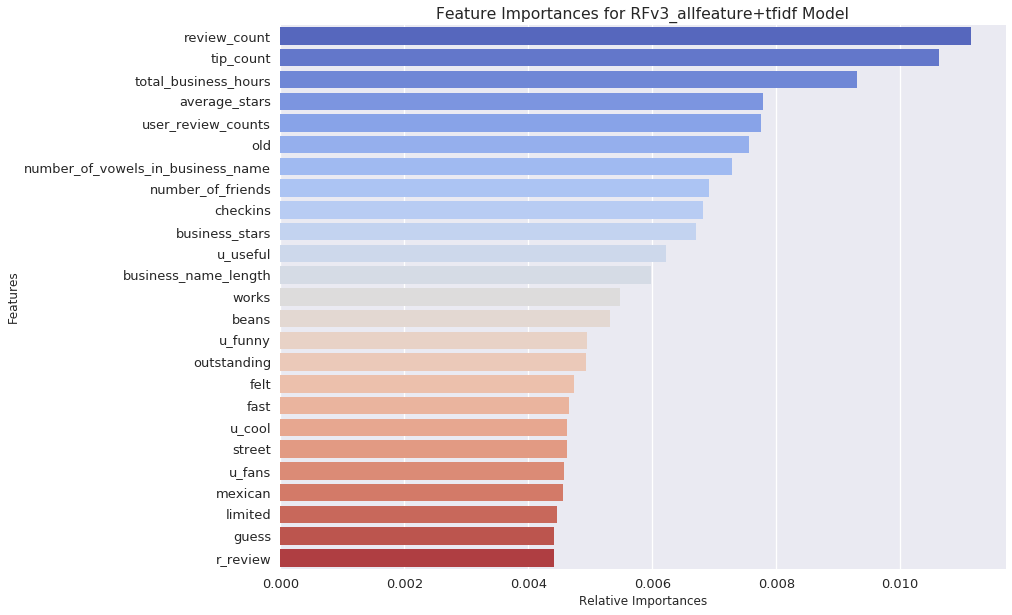

In [37]:
sns.set_context('talk')

plt.figure(figsize=(13,10))
features_, scores_ = zip(*RFv3_feature_importances)
sns.barplot(y=list(features_), x=list(scores_), palette='coolwarm')
plt.title("Feature Importances for RFv3_allfeature+tfidf Model")
plt.ylabel('Features', fontsize=12)
plt.xlabel('Relative Importances', fontsize=12)

Confusion matrix, without normalization


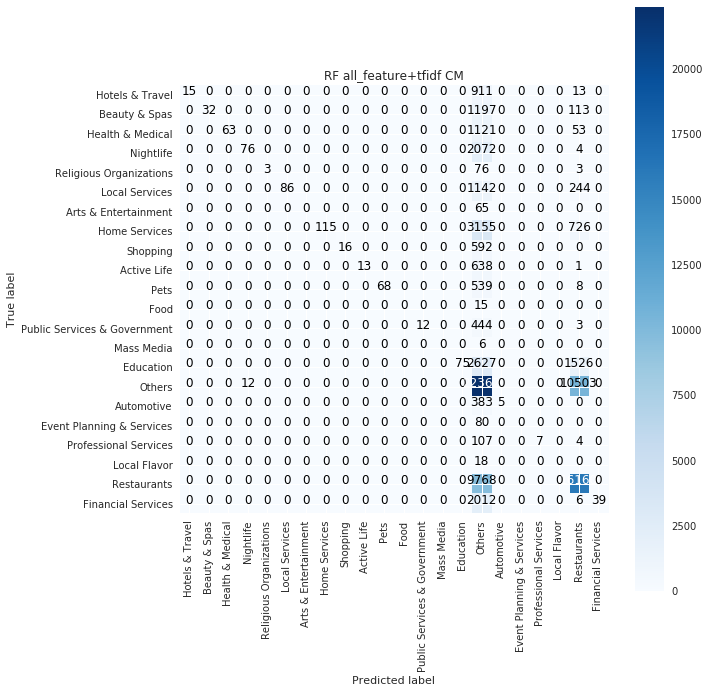

In [38]:
sns.set_context('notebook')
RF_v3_cnf = confusion_matrix(v3_ytest, yelp_v3_RF_pred)
plot_confusion_matrix(RF_v3_cnf, classes=list(set(yelp_tfidf_df.primary_category.tolist())), title='RF all_feature+tfidf CM')

In [40]:
#print('RFv3_allfeature+tfidf recall: {}'.format(np.mean(cross_val_score(yelp_v3_RF, v3_x, v3_y, 
#                                                           cv=3, scoring=make_scorer(metrics.recall_score, average='macro')))))
print('RFv3_allfeature+tfidf F1: {}'.format(np.mean(cross_val_score(yelp_v3_RF, v3_x, v3_y, 
                                                           cv=3, scoring=make_scorer(metrics.f1_score, average='macro')))))

RFv3_allfeature+tfidf F1: 0.05153923427321077


### <a id=8></a> 8. Final Model Optimization

In [ ]:
%%time
xgb_tuned_param=[{'learning_rate':[0.05, 1],'max_depth':[4], 'max_depth':[8], 'objective':['multi:softmax']}]
clf_final = GridSearchCV(xgb.XGBClassifier(), xgb_tuned_param, cv=2, scoring=make_scorer(metrics.f1_score, average='macro'))
clf_final.fit(v2_xtrain, v2_ytrain)

print("Best parameters set found on development set:")
print()
print(clf_final.best_estimator_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf_final.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
             % (mean_score, scores.std() / 2, params))

### <a id=9></a> 9. Final test-scores

In [ ]:
vf_x = yelp_df.drop(['business_name', 'primary_category', 'review_text', 'user_name', 'city', 'state', ], axis = 1)
vf_y = yelp_df.primary_category
vf_xtrain, vf_xtest, vf_ytrain, vf_ytest = train_test_split(vf_x, vf_y, test_size=0.2,random_state=42)
vf_xtrain, vf_xval, vf_ytrain, vf_yval = train_test_split(vf_xtrain, vf_ytrain, test_size=0.25, random_state=2)

vf_xtrain.drop(vf_xtrain.columns[15], axis=1, inplace=True)
vf_xtest.drop(vf_xtest.columns[15], axis=1, inplace=True)
vf_xval.drop(vf_xval.columns[15], axis=1, inplace=True)

In [ ]:
yelp_gbm_final = xgb.XGBClassifier(n_estimators=10000, max_depth=4, objective='multi:softmax',
                        learning_rate=0.1, subsample=.8, min_child_weight=3,
                        colsample_bytree=.8, n_jobs=-1)
yelp_gbm_final_model = yelp_gbm_final.fit(vf_xtrain, vf_ytrain, 
                    eval_set=[(vf_xtrain, vf_ytrain),(vf_xval, vf_yval)],eval_metric='merror', early_stopping_rounds=30, verbose=True)

In [ ]:
recall_score(vf_ytest, yelpv2_gbm.predict(vf_xtest, ntree_limit=yelpv2_gbm.best_ntree_limit), average='macro')
f1_score(vf_ytest, yelpv2_gbm.predict(vf_xtest, ntree_limit=yelpv2_gbm.best_ntree_limit), average='macro')